## Distance Fluctuations

In [1]:
from make_model import loadModes, modeCalc

In [2]:
pdb = '2e0z'
n_modes = 300
evals, evecs, kirch = loadModes(pdb, n_modes)

../results/models/2e0zanmmodes.npz
Loading anm Modes
Slicing Modes up to 300
(126000, 300)


In [3]:
from make_model import distanceFlucts

In [4]:
n_calc = 3*int(kirch.shape[0]/(180))
kirchD = kirch.copy()
kirchD[:n_calc,:n_calc] = 1

C:\Users\colin\miniconda3\envs\odep\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


300
Direct Calculation Method
0.39409307542761546
0.0
Plotting Fluctuation Histogram


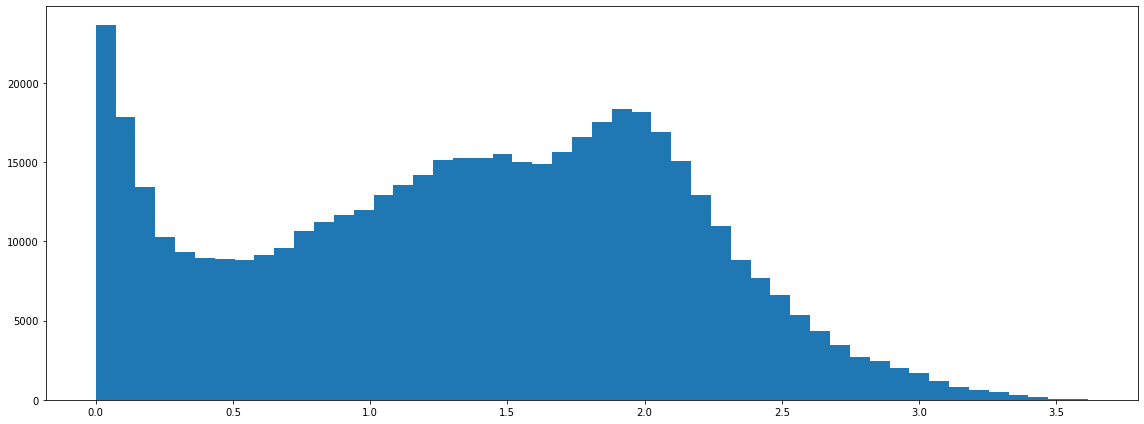

In [5]:
distFlucts = distanceFlucts(evals, evecs[:n_calc,:], kirchD[:n_calc,:n_calc], n_modes)

In [6]:
import numpy as np
dat = np.load('../results/subdivisions/' + pdb + '_sqFlucts.npz')
k = dat['k']
gamma = (8 *np.pi**2)/k
print(gamma)

62.4527893944065


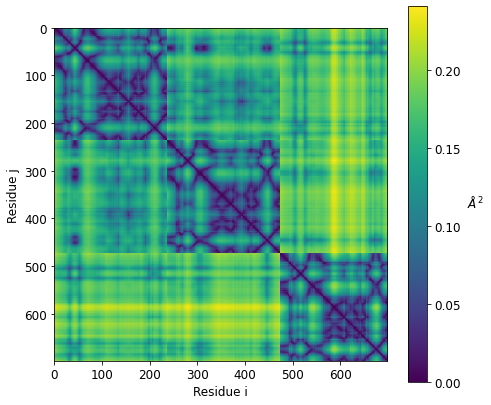

In [12]:
import matplotlib
font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 12}
matplotlib.rc('font', **font)

plotMatD = np.sqrt(distFlucts[:n_calc, :n_calc].todense()/gamma)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,6))
mat = ax.imshow(plotMatD, interpolation='none')
ax.set_xlabel('Residue i')
ax.set_ylabel('Residue j')
cb = plt.colorbar(mat)
cb.ax.get_yaxis().labelpad = 15
cb.set_label(r'$Å^2$', rotation=0)
fig.tight_layout()
plt.savefig('../results/subdivisions/' + pdb + 'dflucts.svg')
plt.show()

300
Direct Calculation Method
0.0
0.0
Plotting Fluctuation Histogram


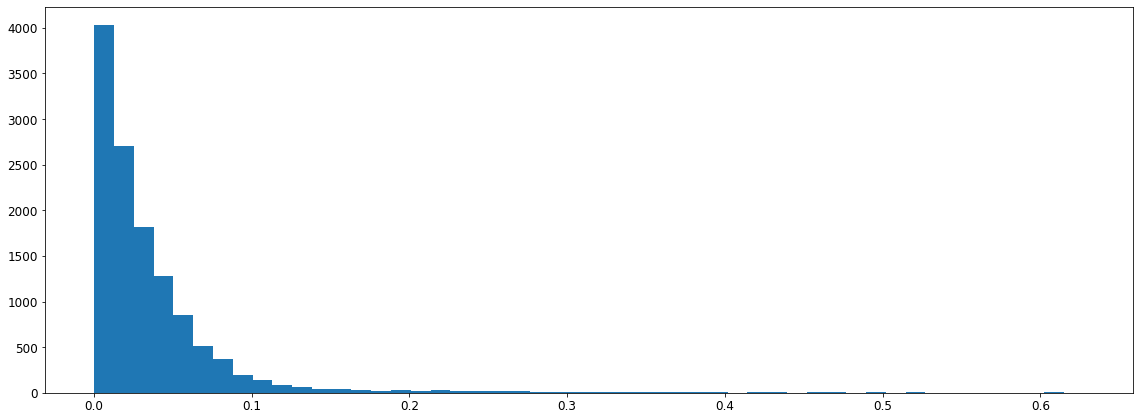

In [31]:
from make_model import fluctToSims
from scipy import sparse
distFlucts = distanceFlucts(evals, evecs[:n_calc,:], kirch[:n_calc,:n_calc], n_modes)
sims = fluctToSims(distFlucts, pdb)

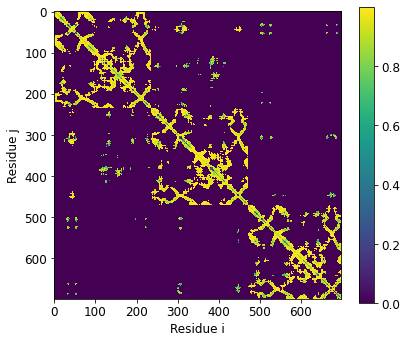

In [33]:
import matplotlib
font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 12}
matplotlib.rc('font', **font)

plotMat = np.sqrt(sims.todense()[:int(n_calc), :int(n_calc)])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
mat = ax.imshow(plotMat, interpolation='none')
ax.set_xlabel('Residue i')
ax.set_ylabel('Residue j')
cb = plt.colorbar(mat)
cb.ax.get_yaxis().labelpad = 15
#cb.set_label(r'$Å^2$', rotation=0)
fig.tight_layout()
plt.savefig('../results/subdivisions/' + pdb + 'sims.svg')
plt.show()

## Compressibility

In [57]:
%load_ext autoreload
%autoreload 2
import numpy as np
from make_model import getPDB, getPDBx, buildModel, modeCalc
pdb = '7s21'
pdbx = False
if pdbx:
    capsid, calphas, coords, bfactors, title = getPDBx(pdb)
else:
    capsid, calphas, title, header = getPDB(pdb)
    coords = calphas.getCoords()
    bfactors = calphas.getBetas()

m = np.sum(capsid.getMasses())/coords.shape[0]
print(m)
# hess, kirch = buildModel(pdb, calphas, coords, bfactors, cutoff=10)
# evals, evecs = modeCalc(pdb, hess, kirch, 300, 'lobcuda', 'anm')

@> 2041 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 140 residues.
@> Biomolecular transformations were applied to the coordinate data.


AtomGroup 7s21_full biomolecule 1
Number Of Residues:  15900
101.5872426415094


In [58]:
from make_model import loadModes, modeCalc
n_modes = 300
evals, evecs, kirch = loadModes(pdb, n_modes)
if coords.shape[0] == evecs.shape[0]:
    model = 'gnm'
else:
     model='anm'
print(evecs.shape)

../results/models/7s21anmmodes.npz
Loading anm Modes
Slicing Modes up to 300
(47700, 300)
(47700, 300)


In [59]:
from score import volFlucts
from bfactorFit import fluctFit
import numpy as np
nModes, coeff, k, sqFlucts, stderr, r2 = fluctFit(evals, evecs, bfactors)

In [60]:
boltz = 1.38e-23
dalt = 6.022*10**26
bz = boltz*10**20*dalt
T_scale = 270
T_sim = 270

gamma = (8 * np.pi ** 2) / k

stderr =  stderr/k
stderr = gamma*stderr

if model == 'anm':
    gamma = gamma / 3

from bfactorFit import confidenceInterval
ci = confidenceInterval(bfactors, stderr)
print(k, gamma, ci)

gamma = gamma # average mass in daltons per residue
print(gamma)

scale = T_sim*bz

compressibility, vrms, vplot, vmodes = volFlucts(coords, evals, evecs, gamma=gamma)
print(np.sqrt(scale*vrms), compressibility)

68.82790293953894 0.38238772279160077 0.06995152933976793
0.38238772279160077
(15900, 3)
(47700, 300)
vol 5794713.945893765
827126090.7305843
8
5.002283182914517e+17 192.4513420062009


In [61]:
scgs = 1e-8*6.022e23
print(scgs*compressibility)
spa = 1e-10*6.022e26
print(spa*compressibility*10e9)

1.1589419815613417e+18
1.1589419815613418e+29


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting


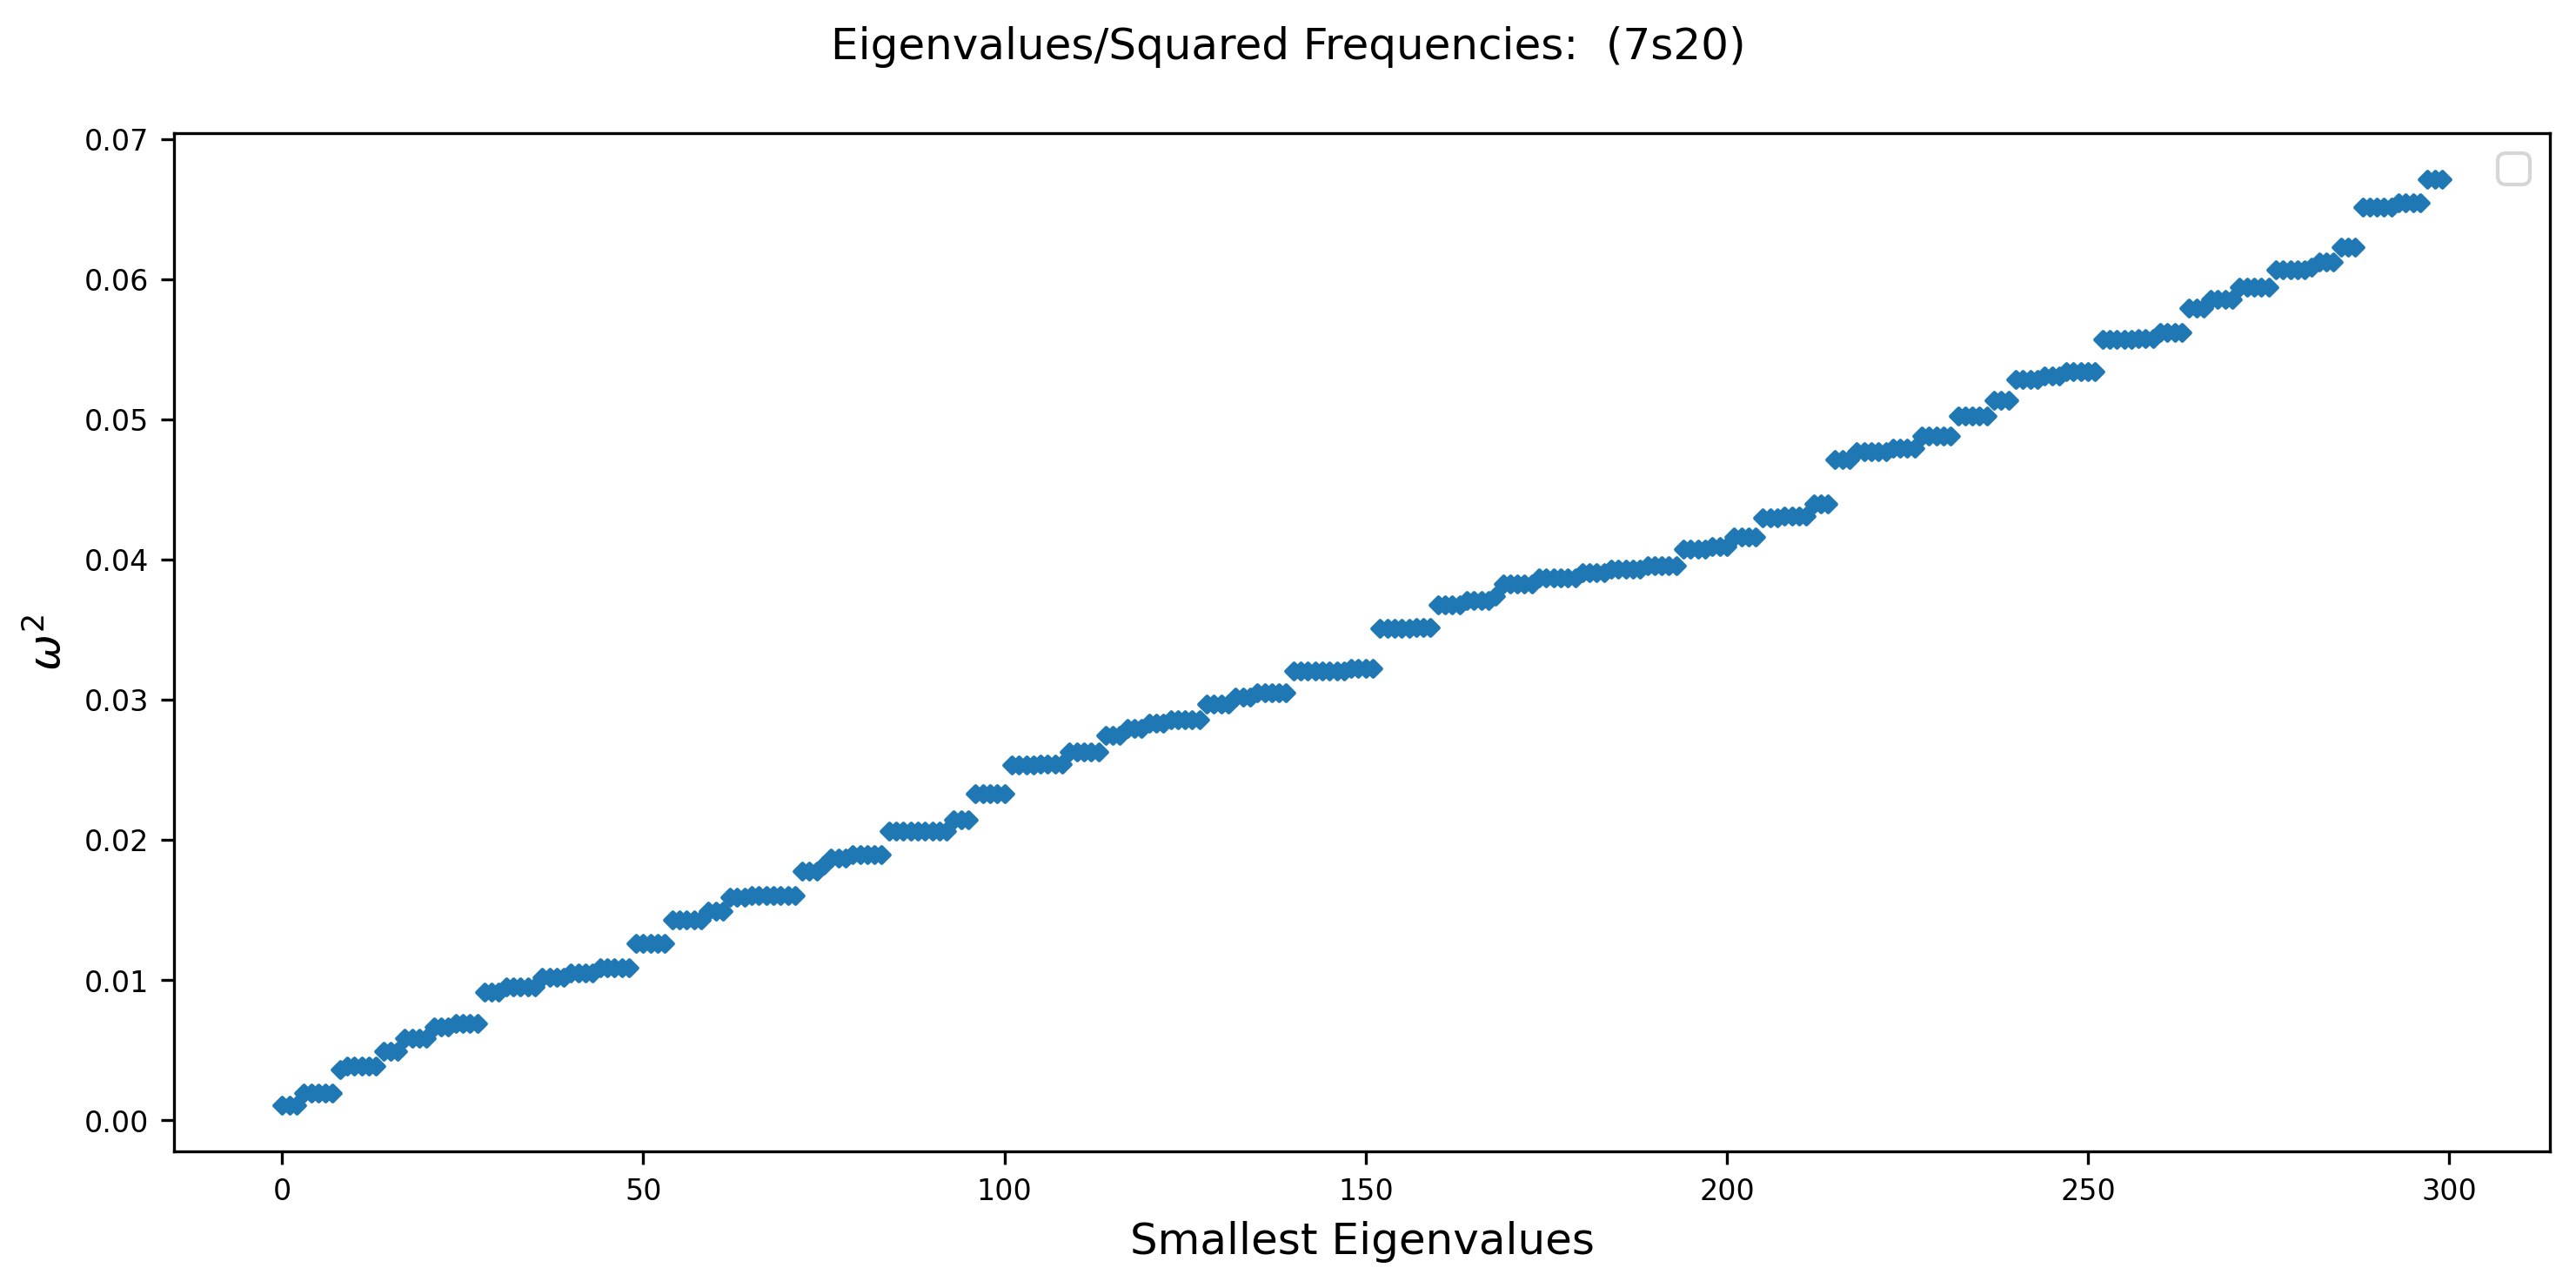

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting compressibility by modes


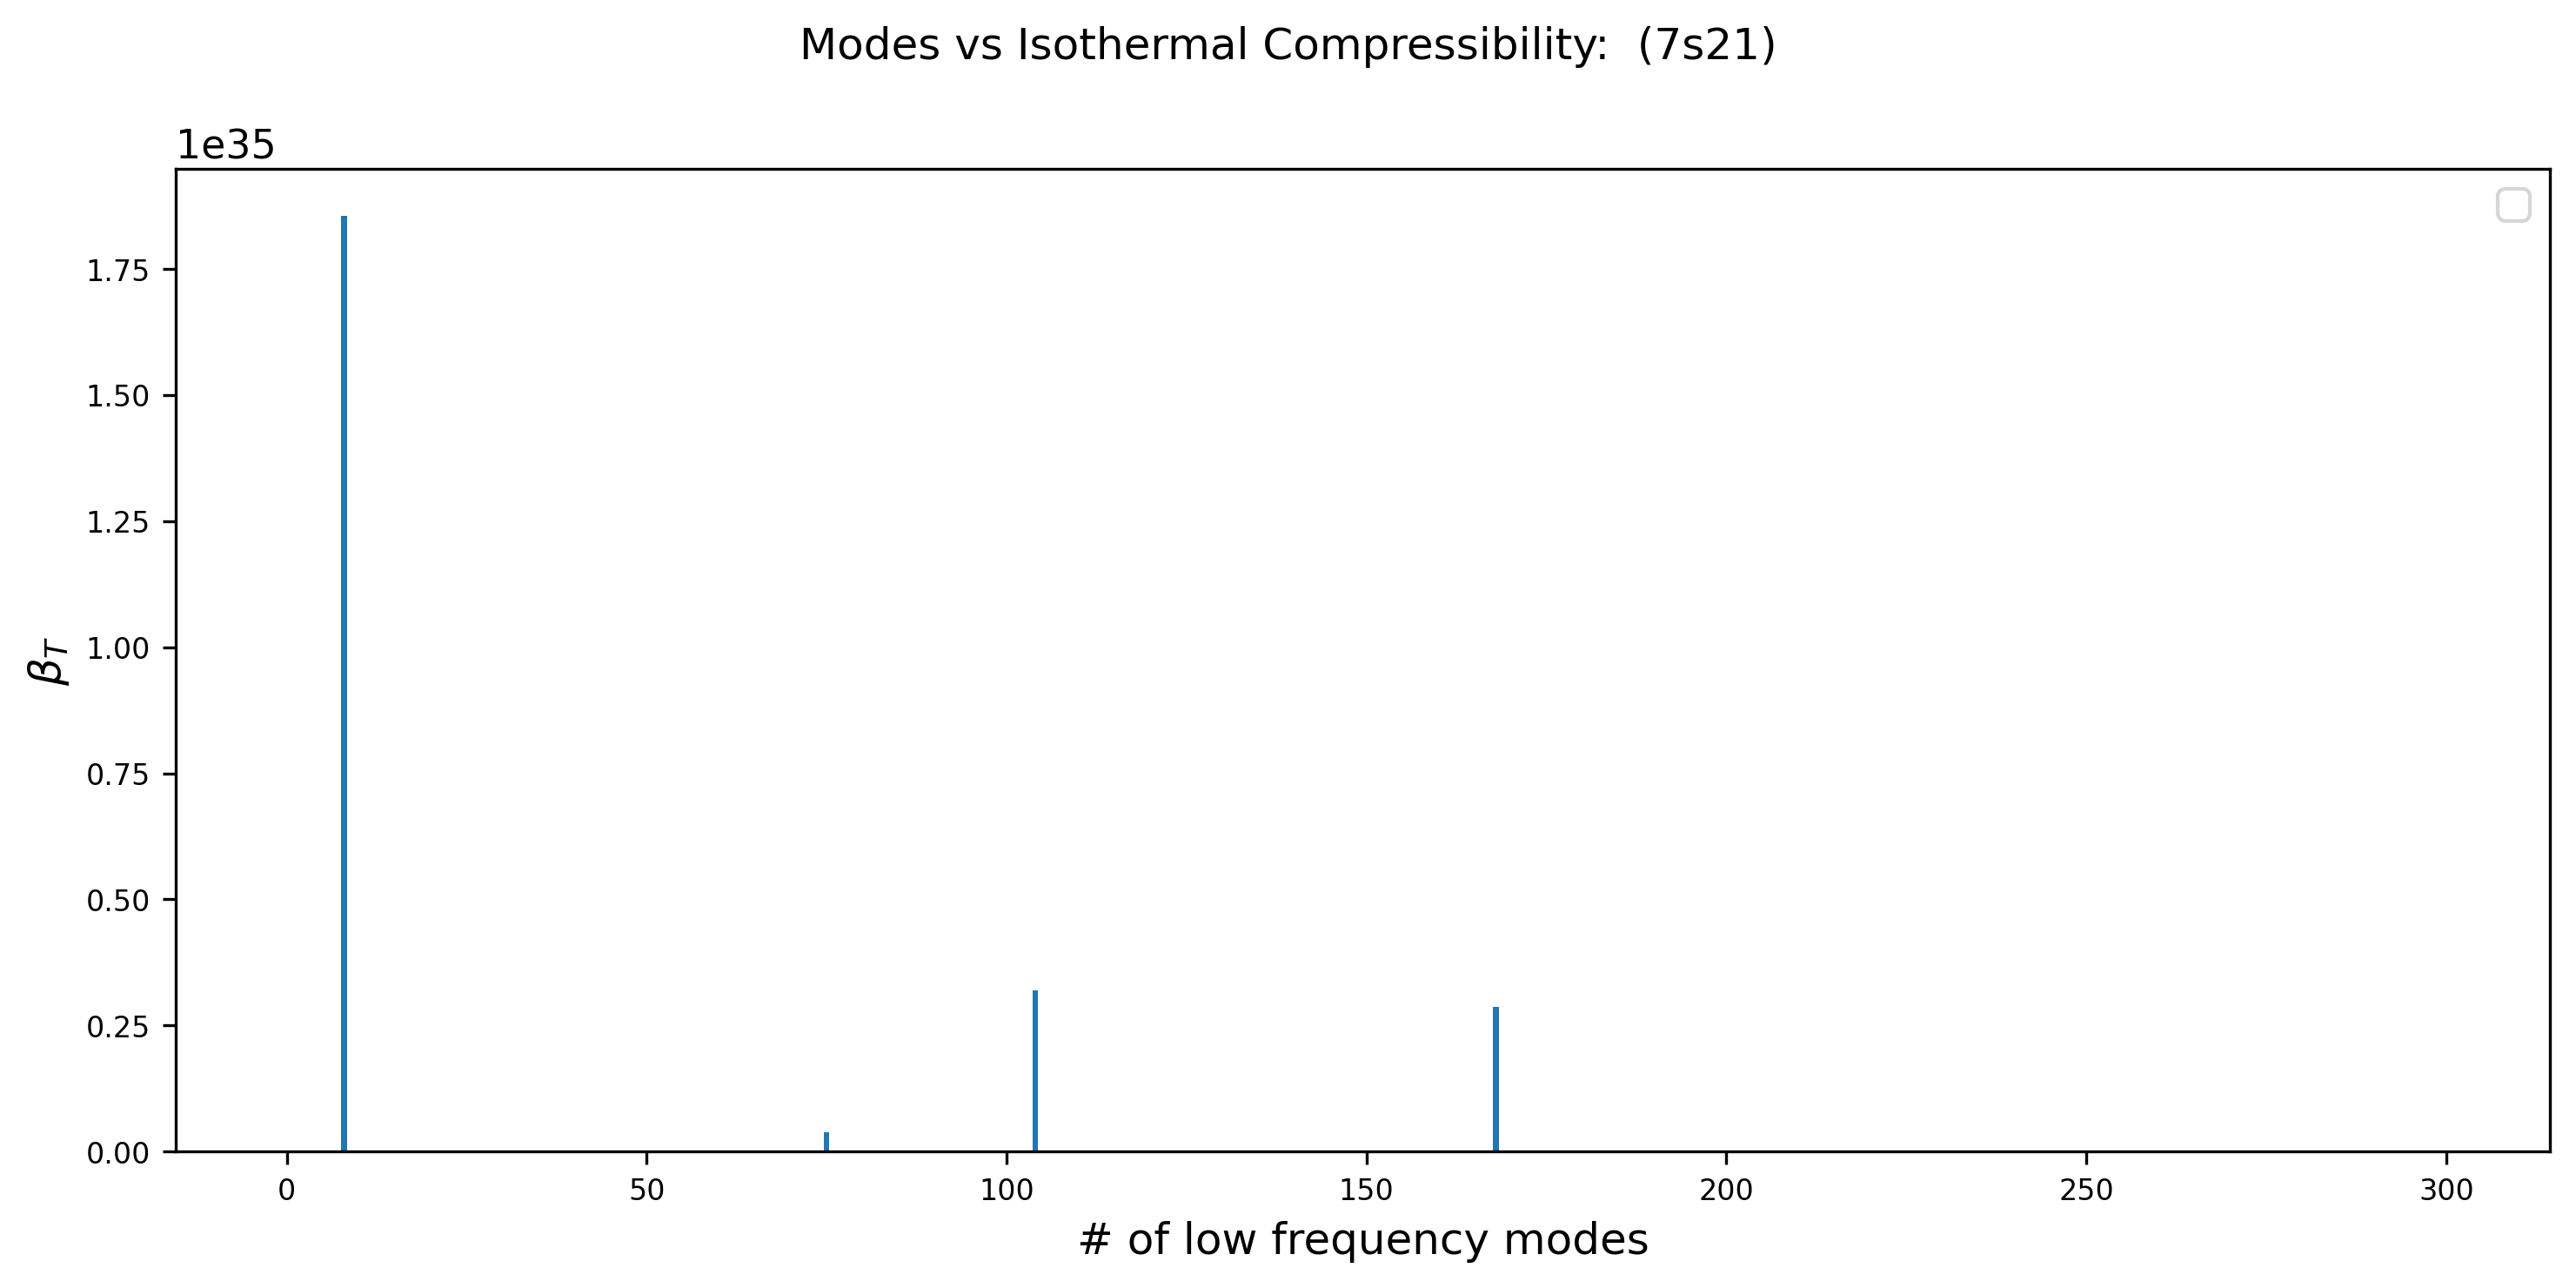

In [62]:
import matplotlib.pyplot as plt
import matplotlib
from make_model import evPlot
evPlot(evals, evecs, title)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 11}
matplotlib.rc('font', **font)
print('Plotting compressibility by modes')
ax.set_ylabel(r'$\beta_{T}$', fontsize=12)
ax.set_xlabel('# of low frequency modes', fontsize=12)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.legend()
fig.suptitle(
    'Modes vs Isothermal Compressibility: ' + ' (' + pdb + ')', fontsize=12)

#ax.scatter(np.arange(vplot.shape[0]), scale*vplot, marker='D', s=10, label='eigs')
ax.bar(np.arange(vplot.shape[0]), scale*vplot)
fig.tight_layout()
plt.savefig('../results/subdivisions/' + pdb + '_evals.png')
plt.show()

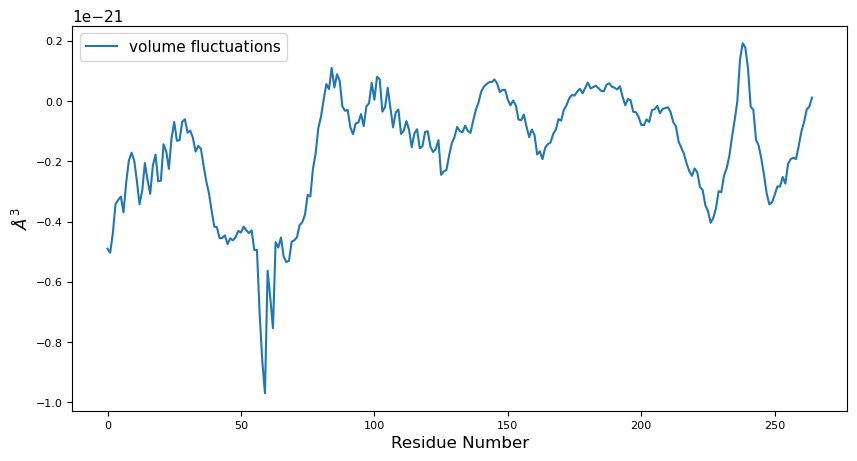

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 11}
matplotlib.rc('font', **font)


n_asym = int(bfactors.shape[0]/60)
#np.savez('../results/subdivisions/' + pdb + '_sqFlucts.npz', sqFlucts=sqFlucts, bf=bfactors, k=k, cc=coeff, nModes=nModes)
ax.plot(np.arange(bfactors.shape[0])[:int(n_asym)], vmodes[:int(n_asym)], label='volume fluctuations')

ax.set_ylabel(r'$Å^{3}$', fontsize=12)
ax.set_xlabel('Residue Number', fontsize=12)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)

ax.legend()
# fig.suptitle(
#     'Squared Fluctuations vs B-factors: '  + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(
#         gamma) +  r'$\pm$' + "{:.5f}".format(ci) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff)  + '  r2 = ' + "{:.5f}".format(r2), fontsize=12)
# fig.suptitle('# Modes: ' + str(nModes) + ' Corr. Coeff: ' + str(coeff) + ' Spring Constant: ' + str(gamma), fontsize=16)
# fig.tight_layout()
# plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.svg')
# plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.png')
plt.show()

## Score Plot

Plotting
[  0.  50. 100. 150. 200. 250.]
[  0.  50. 100. 150. 200. 250. 238.]
6nj8_238_domains.png


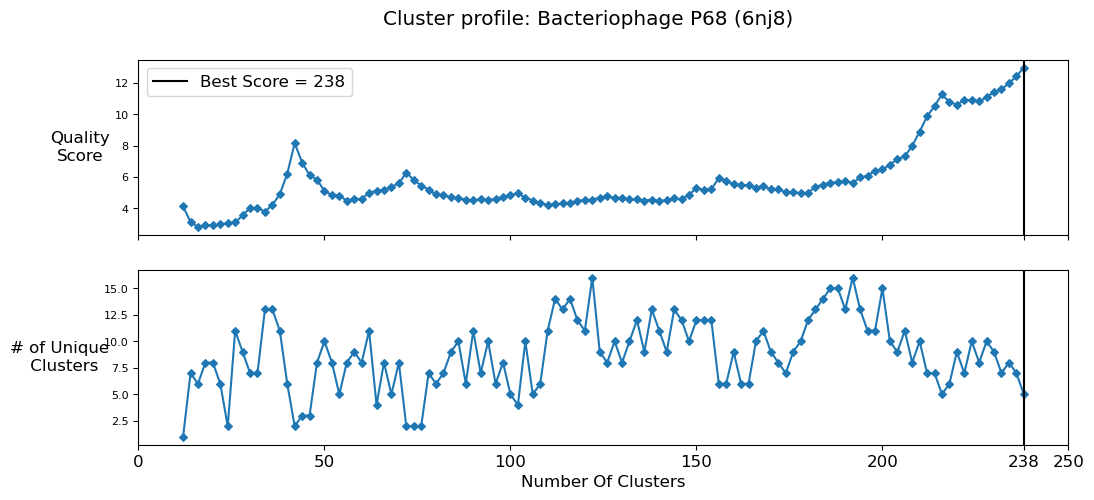

In [1]:
from score import plotScores
import numpy as np

pdb = '6nj8'
nstart = 12
nstop = 240
nstep = 2

n_range = np.arange(nstart,nstop,nstep)

import matplotlib
import matplotlib.pyplot as plt
from make_model import getPDB

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}

#_, _, title = getPDB(pdb)

title = 'Bacteriophage P68'

matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')


scores = []
vars = []
ntypes = []
inerts = []
for i in range(len(n_range)):
    nc = n_range[i]
    results = np.load('../results/subdivisions/' + pdb + '/' + pdb + '_' + str(nc) + '_results.npz')
    score = results['score']
    ntype = results['ntypes']
    var = results['var']
    #inert = results['inertia']
    scores.append(score)
    vars.append(var)
    ntypes.append(ntype)
    #inerts.append(inert)
scores = np.array(scores)
vars = np.array(vars)
ntypes = np.array(ntypes)


print('Plotting')
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fig.suptitle('Cluster profile: ' + title.title() + ' (' + pdb + ')')

ax[0].scatter(n_range, scores, marker='D', s=15)
ax[0].plot(n_range, scores)
ax[1].plot(n_range, ntypes)
ax[1].scatter(n_range, ntypes, marker='D', s=15)
#ax[2].scatter(n_range, inerts, marker='D', s=15)
#ax[2].plot(n_range, inerts)
ax[0].axvline(x=n_range[np.argmax(scores)], label='Best Score = ' + str(n_range[np.argmax(scores)]) , color='black')
ax[1].axvline(x=n_range[np.argmax(scores)], label='Best Score', color='black')

nc = str(n_range[np.argmax(scores)])
# ax[0].set_xticks(n_range)
ax[1].set_xlim([0, n_range[-1]])
ticks = ax[0].get_xticks()
print(ticks)
ticks = np.append(ticks, n_range[np.argmax(scores)])

ax[1].set_xlabel('Number Of Clusters')
ax[0].set_ylabel('Quality' + '\n' + 'Score', rotation='horizontal', ha='center', va='center', labelpad=25)
ax[1].set_ylabel('# of Unique \n Clusters', rotation='horizontal', ha='center', va='center', labelpad=30)
#ax[2].set_ylabel('Cluster \n Inertia', rotation='horizontal', ha='center', va='center', labelpad=25)

ax[0].tick_params(axis='y', labelsize=8)
ax[1].tick_params(axis='y', labelsize=8)
#ax[2].tick_params(axis='y', labelsize=8)

print(ticks)
ax[0].legend()
#fig.delaxes(ax[2])
ax[1].set_xticks(ticks, fontsize=6)
# fig.tight_layout()
print(pdb + '_' + nc + '_domains.png')
plt.savefig('../results/subdivisions/' + pdb + '_' + nc + '_domains.png')
plt.show()

In [9]:
from score import plotScores
import numpy as np
pdb = '5l35'
title = 'Phage P22'
nstart = 12
nstop = 500
nstep = 2

n_range = np.arange(nstart,nstop,nstep)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from make_model import getPDB

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 6}

#_, _, title = getPDB(pdb)

matplotlib.rc('font', **font)
#matplotlib.rc('svg', fonttype='none')


scores = []
vars = []
ntypes = []
inerts = []
for i in range(len(n_range)):
    nc = n_range[i]
    results = np.load('../results/subdivisions/' + pdb + '/' + pdb + '_' + str(nc) + '_results.npz')
    score = results['score']
    ntype = results['ntypes']
    var = results['var']
    #inert = results['inertia']
    scores.append(score)
    vars.append(var)
    ntypes.append(ntype)
    #inerts.append(inert)
scores = np.array(scores)
vars = np.array(vars)
ntypes = np.array(ntypes)

print('Best Scores')
#ind = np.argpartition(scores,-50)[-50:]
ind = np.argsort(scores)[-30:]
print(n_range[ind][::-1])

ind = np.argsort(vars)[-10:]
print(n_range[ind][::-1])

print('Plotting')
fig, ax = plt.subplots(2, 1, figsize=(4, 1.8), sharex=True)
fig.suptitle('k profile: ' + title.title() + ' (' + pdb + ')', fontsize=6)
ax[0].scatter(n_range, scores, marker='D', s=2)
ax[0].plot(n_range, scores)
ax[1].plot(n_range, ntypes)
ax[1].scatter(n_range, ntypes, marker='D', s=2)
ax[0].axvline(x=n_range[np.argmax(scores)], label='Best Score = ' + str(n_range[np.argmax(scores)]) , color='black')
ax[1].axvline(x=n_range[np.argmax(scores)], label='Best Score', color='black')
ax[1].set_xlim([0, nstop])
ax[0].set_xlim([0, nstop])
ticks = ax[0].get_xticks()
ticks = np.append(ticks, n_range[np.argmax(scores)])
ax[1].set_xlabel('Number Of Clusters')
ax[0].set_ylabel('Quality' + '\n' + 'Score', rotation='horizontal', ha='center', va='center', labelpad=15)
ax[1].set_ylabel('# of Unique \n Clusters', rotation='horizontal', ha='center', va='center', labelpad=20)

ax[0].tick_params(axis='y', labelsize=5)
ax[1].tick_params(axis='y', labelsize=5)

ax[0].legend(fontsize=5, frameon=False)
ax[1].set_xticks(ticks, fontsize=5, prop={'size': 4})
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + pdb + '_score_final.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + pdb + '_score_final.png', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../results/subdivisions/5l35/5l35_12_results.npz'

## Squared Fluctuations Figure

In [33]:
pdb = '3j40'
from settings import model
from make_model import getPDB, loadModes
capsid, calphas, title, header = getPDB(pdb)
coords = calphas.getCoords()
bfactors = calphas.getBetas()
n_asym = int(kirch.shape[0]/(60))

@> 24066 atoms and 1 coordinate set(s) were parsed in 0.61s.
@> Secondary structures were assigned to 708 residues.
@> Biomolecular transformations were applied to the coordinate data.


AtomGroup 3j40_full biomolecule 1
Number Of Residues:  187320


In [34]:
from bfactorFit import fluctFit
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from score import collectivity, meanCollect, effectiveSpringConstant, overlapStiffness, globalPressure
print('Plotting')
n_modes = 800
evals, evecs, kirch = loadModes(pdb, n_modes)
nModes, coeff, k, sqFlucts, stderr, r2 = fluctFit(evals, evecs, bfactors)

Plotting
../results/models/3j40anmmodes.npz
Loading anm Modes
Slicing Modes up to 800
(561960, 800)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting
17.687530948996294


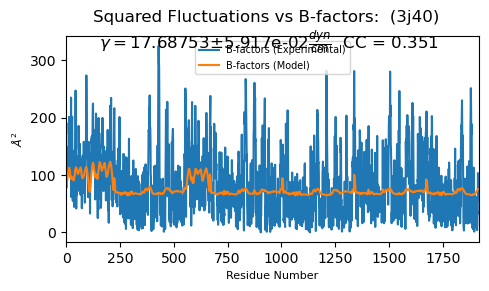

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8/1.5, 4/1.5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

m = 1
print('Plotting')
boltz = 1.380649e-23
dalt = 6.022173643 * 10 ** 26
bz = boltz * 10 ** 20 * dalt
T_scale = 270
T_sim = 270

gamma =  (8 * np.pi ** 2) / k

if model == 'anm':
    gamma = gamma / 3

gamma = gamma * m  # average mass in daltons per residue
gcgs = 1.66054e-24
gamma_cgs = gamma
print(gamma_cgs)
scale = T_sim * bz


stderr =  stderr/k
stderr = gamma_cgs * stderr
from bfactorFit import confidenceInterval
ci = confidenceInterval(bfactors, stderr)

ax.legend()
fig.suptitle(
    'Squared Fluctuations vs B-factors: '  + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(
        gamma_cgs) +  r'$\pm$' + "{:.3e}".format(ci) + r'$ \frac{dyn}{cm}$' + '  CC = ' + "{:.3f}".format(coeff), fontsize=12)
# fig.suptitle('# Modes: ' + str(nModes) + ' Corr. Coeff: ' + str(coeff) + ' Spring Constant: ' + str(gamma), fontsize=16)
# fig.tight_layout()
# plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.svg')
# plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.png')
# plt.show()

ax.plot(np.arange(bfactors.shape[0])[:int(n_asym)], bfactors[:int(n_asym)], label='B-factors (Experimental)')
ax.plot(np.arange(sqFlucts.shape[0])[:int(n_asym)], sqFlucts[:int(n_asym)], label='B-factors (Model)')
ax.set_ylabel(r'$Å^{2}$', fontsize=8)
ax.set_xlabel('Residue Number', fontsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim([-1,n_asym])
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

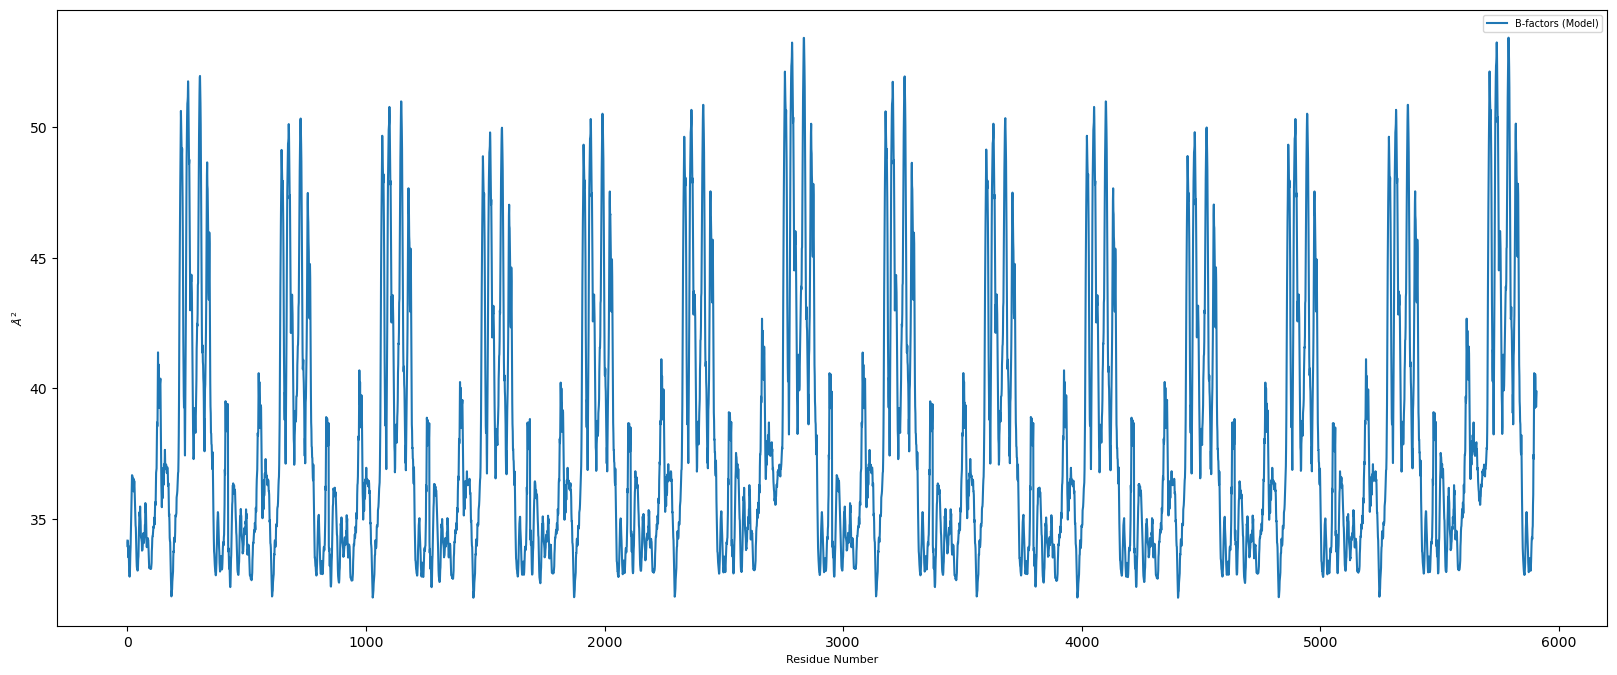

In [13]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

data = np.load('../results/subdivisions/' + pdb + '_sqFlucts.npz')
sqFlucts = data['sqFlucts']
n = sqFlucts.shape[0]
nplot = int(n/30)

ax.plot(np.arange(nplot), sqFlucts[:nplot], label='B-factors (Model)')
ax.set_ylabel(r'$Å^{2}$', fontsize=8)
ax.set_xlabel('Residue Number', fontsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
#ax.set_xlim([-1,n_asym])
ax.legend()
#fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) +  r'$\pm$' + "{:.5f}".format(stderr) + r' $k_{b}T/Å^{2}$' + '  CC = ' + "{:.5f}".format(coeff), fontsize=8)
#plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Figs/' + pdb + '_sqFlucts_final.svg')
plt.show()

In [1]:
from optcutoff import fluctFit
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from score import collectivity, meanCollect, effectiveSpringConstant, overlapStiffness, globalPressure
_, _, title = getPDB(pdb)
print('Plotting')
nModes, coeff, k, sqFlucts = fluctFit(evals, evecs, bfactors)

ModuleNotFoundError: No module named 'optcutoff'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


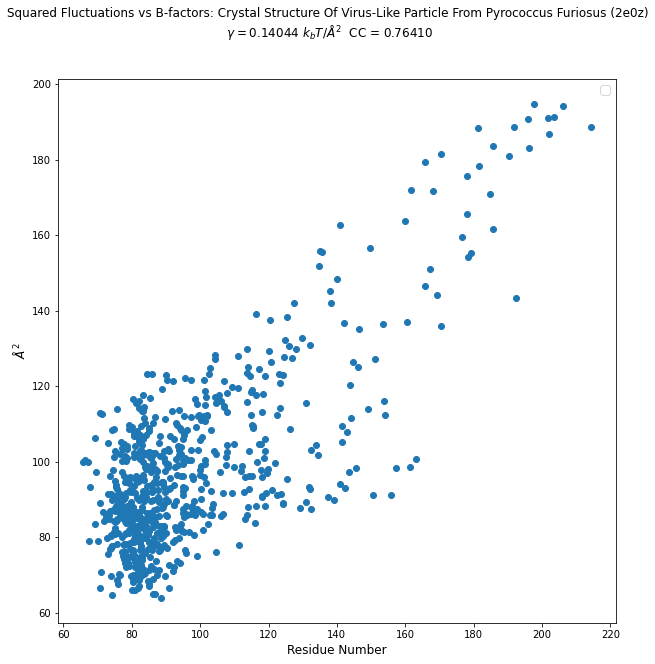

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

gamma = (8 *np.pi**2)/k

bf = bfactors[:int(n_asym)]
sf = sqFlucts[:int(n_asym)]
ind = np.argsort(bf)
bf = bf[ind]
sf = sf[ind]
rg = np.arange(bf.shape[0])

ax.scatter(sf,bf)
#ax.scatter(rg,sf, label='sf')
#ax.scatter(rg,bf)
ax.set_ylabel(r'$Å^{2}$', fontsize=12)
ax.set_xlabel('Residue Number', fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

ax.legend()
fig.suptitle('Squared Fluctuations vs B-factors: ' + title.title() + ' (' + pdb + ')' + "\n" + r' $\gamma = $' + "{:.5f}".format(gamma) + r' $k_{b}T/Å^{2}$' + '  CC = ' +"{:.5f}".format(coeff) ,fontsize=12)
plt.savefig('../results/subdivisions/' + pdb + '_sqFlucts.svg')
plt.show()

## Memory Plot

In [90]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg')
matplotlib.rcParams['figure.dpi'] = 300

In [91]:
import pandas as pd
import numpy as np
table = pd.read_excel('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/results_table_correct.xlsx').set_index('PDB')
table = table.drop('5zap')
mib = np.array(table['Mem Usage'])
res = np.array(table['Residues'])
mb = 1.0486*np.array(mib)/1000

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              299.9
Date:                Mon, 10 Oct 2022   Prob (F-statistic):                    4.57e-15
Time:                        06:07:07   Log-Likelihood:                         -89.437
No. Observations:                  25   AIC:                                      180.9
Df Residuals:                      24   BIC:                                      182.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

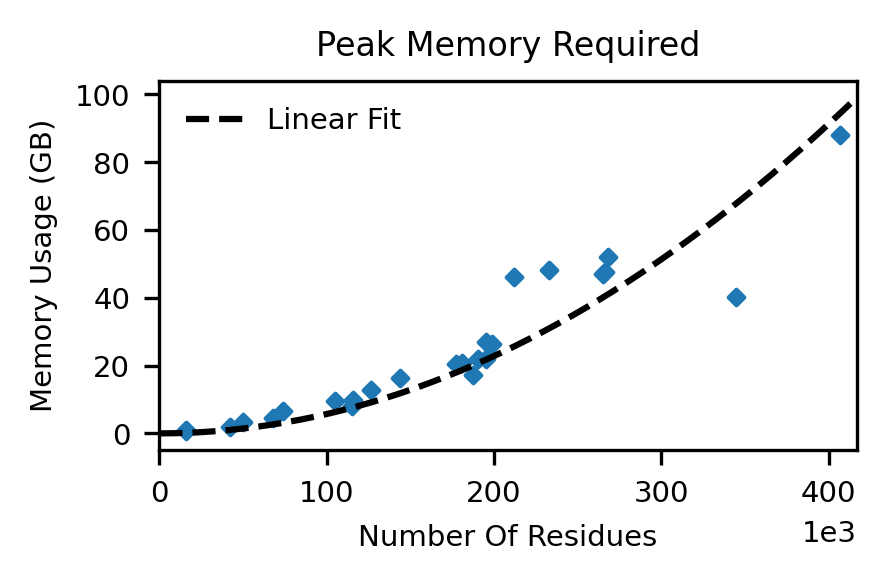

In [93]:
res = np.array(table['Residues'])
import statsmodels.api as sm

R = res**2

model = sm.OLS(mb,R)
results = model.fit()
print(results.summary())
params = results.params
r2 = results.rsquared
stderr = results.bse
pv = results.pvalues



poly = np.poly1d([params[0],0,0])

print(np.var(mb))
print('slope: ', "{:.5e}".format(params[0]))
print('r2: ', r2)
print('p-value: ', pv)
x = np.linspace(0,np.max(res) + 10000)
print('stderr: ', stderr)
fig, ax = plt.subplots(1, 1, figsize = (3,1.6))
ax.set_title('Peak Memory Required', fontsize=8)
ax.plot(x, poly(x), '--', label='Linear Fit', color='black' )

ax.scatter(res, mb, marker='D', s=7)

#ax.plot(x, line(x), label='Maximum Memory', color='black')
#ax.hlines(32,0,2*np.max(res), label='Maximum Memory')
ax.set_ylabel('Memory Usage (GB)', fontsize=7)
ax.set_xlabel('Number Of Residues', fontsize=7)
ax.set_xlim(0,np.max(res) + 10000)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ticklabel_format(axis='x',style='sci', scilimits=(3,3))
ax.legend(frameon=False, fontsize=7)
# fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + 'memPlot_testing.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + 'memPlot_testing.png')

plt.show()

In [68]:
t = np.array(table['Runtime'])
t = np.array(t)/3600
res = np.array(table['Residues'])

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              416.2
Date:                Thu, 06 Oct 2022   Prob (F-statistic):                    1.14e-16
Time:                        18:01:59   Log-Likelihood:                         -58.913
No. Observations:                  25   AIC:                                      119.8
Df Residuals:                      24   BIC:                                      121.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

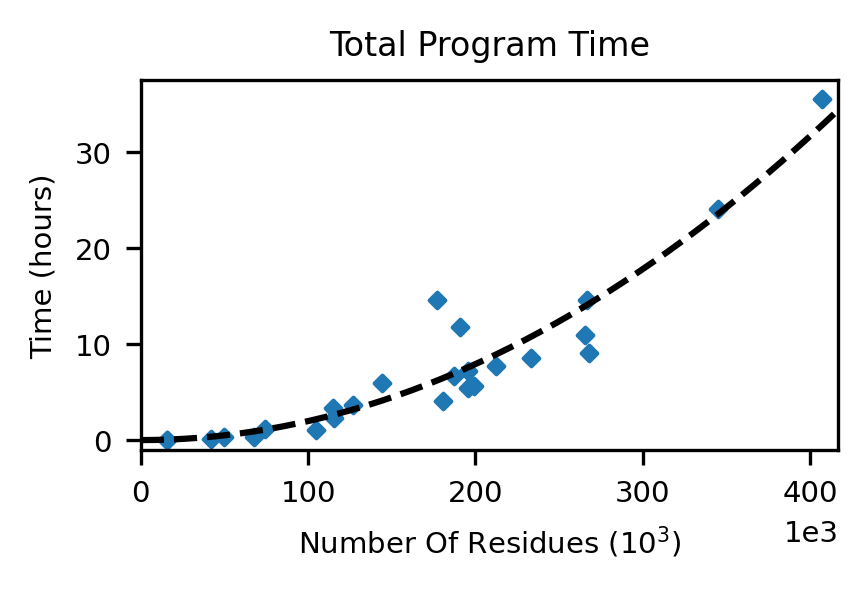

In [71]:
R = res**2

model = sm.OLS(t,R)
results = model.fit()
print(results.summary())
params = results.params
r2 = results.rsquared
stderr = results.bse
pv = results.pvalues


print('SSR: ', residuals)
print('slope: ', params)
print('r2: ', r2)
print('p-value: ', pv)
print('stderr: ', stderr)
poly = np.poly1d([params[0],0,0])

x = np.linspace(0,np.max(res) + 10000)
fig, ax = plt.subplots(1, 1, figsize = (3,1.6))
ax.set_title('Total Program Time', fontsize=8)
ax.plot(x, poly(x), '--', label='Linear Fit', color='black')
ax.scatter(res, t, marker='D', s=7)
ax.set_ylabel('Time (hours)', fontsize=7)
ax.set_xlabel('Number Of Residues ($10^3$)', fontsize=7)
ax.set_xlim(0,np.max(res) + 10000)
ax.set_ylim(-1, np.max(t)+2)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ticklabel_format(axis='x',style='sci', scilimits=(3,3))
#ax.legend()
# fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + 'timePlot_testing.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/' + 'timePlot_testing.png')
plt.show()

# RESULTS DATA

In [96]:
import pandas as pd
import numpy as np
# table = pd.read_csv('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/results_table_correct.csv', sep=',')
table = pd.read_excel('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/results_table_correct.xlsx').set_index('PDB')
table = table.drop('5zap')

print(table)

                 Abbreviation                        Capsid  T0  Residues  \
PDB                                                                         
7kq5         T. Maritima Enc.       T. Maritima. Encapsulin   1     15900   
7s21        M. Xanthus Enc. 2       M. Xanthus Encapsulin 2   1     15900   
2e0z         P. Furiosus Enc.               P. Furiosus VLP   3     42000   
7s20        M. Xanthus Enc. 1       M. Xanthus Encapsulin 1   3     49860   
6nj8           Q. Therm. Enc.          Q. Therm. Encapsulin   4     67740   
6iat                Phage P68              Bateriophage P68   4    104760   
6b23                    SaPi1           80alpha-4 procapsid   4     73920   
6c21            Phage 80alpha             80alpha (capsid)    7    115500   
3j4u         Bordetella Phage              Bordetella Phage   7    195240   
5uu5                Phage P22                     Phage P22   7    180600   
5l35                Phage SF6                     Phage Sf6   7    177240   

## Capsid Correlation Results

mean CC:  0.5192800000000001
stdev CC:  0.21095753506333925


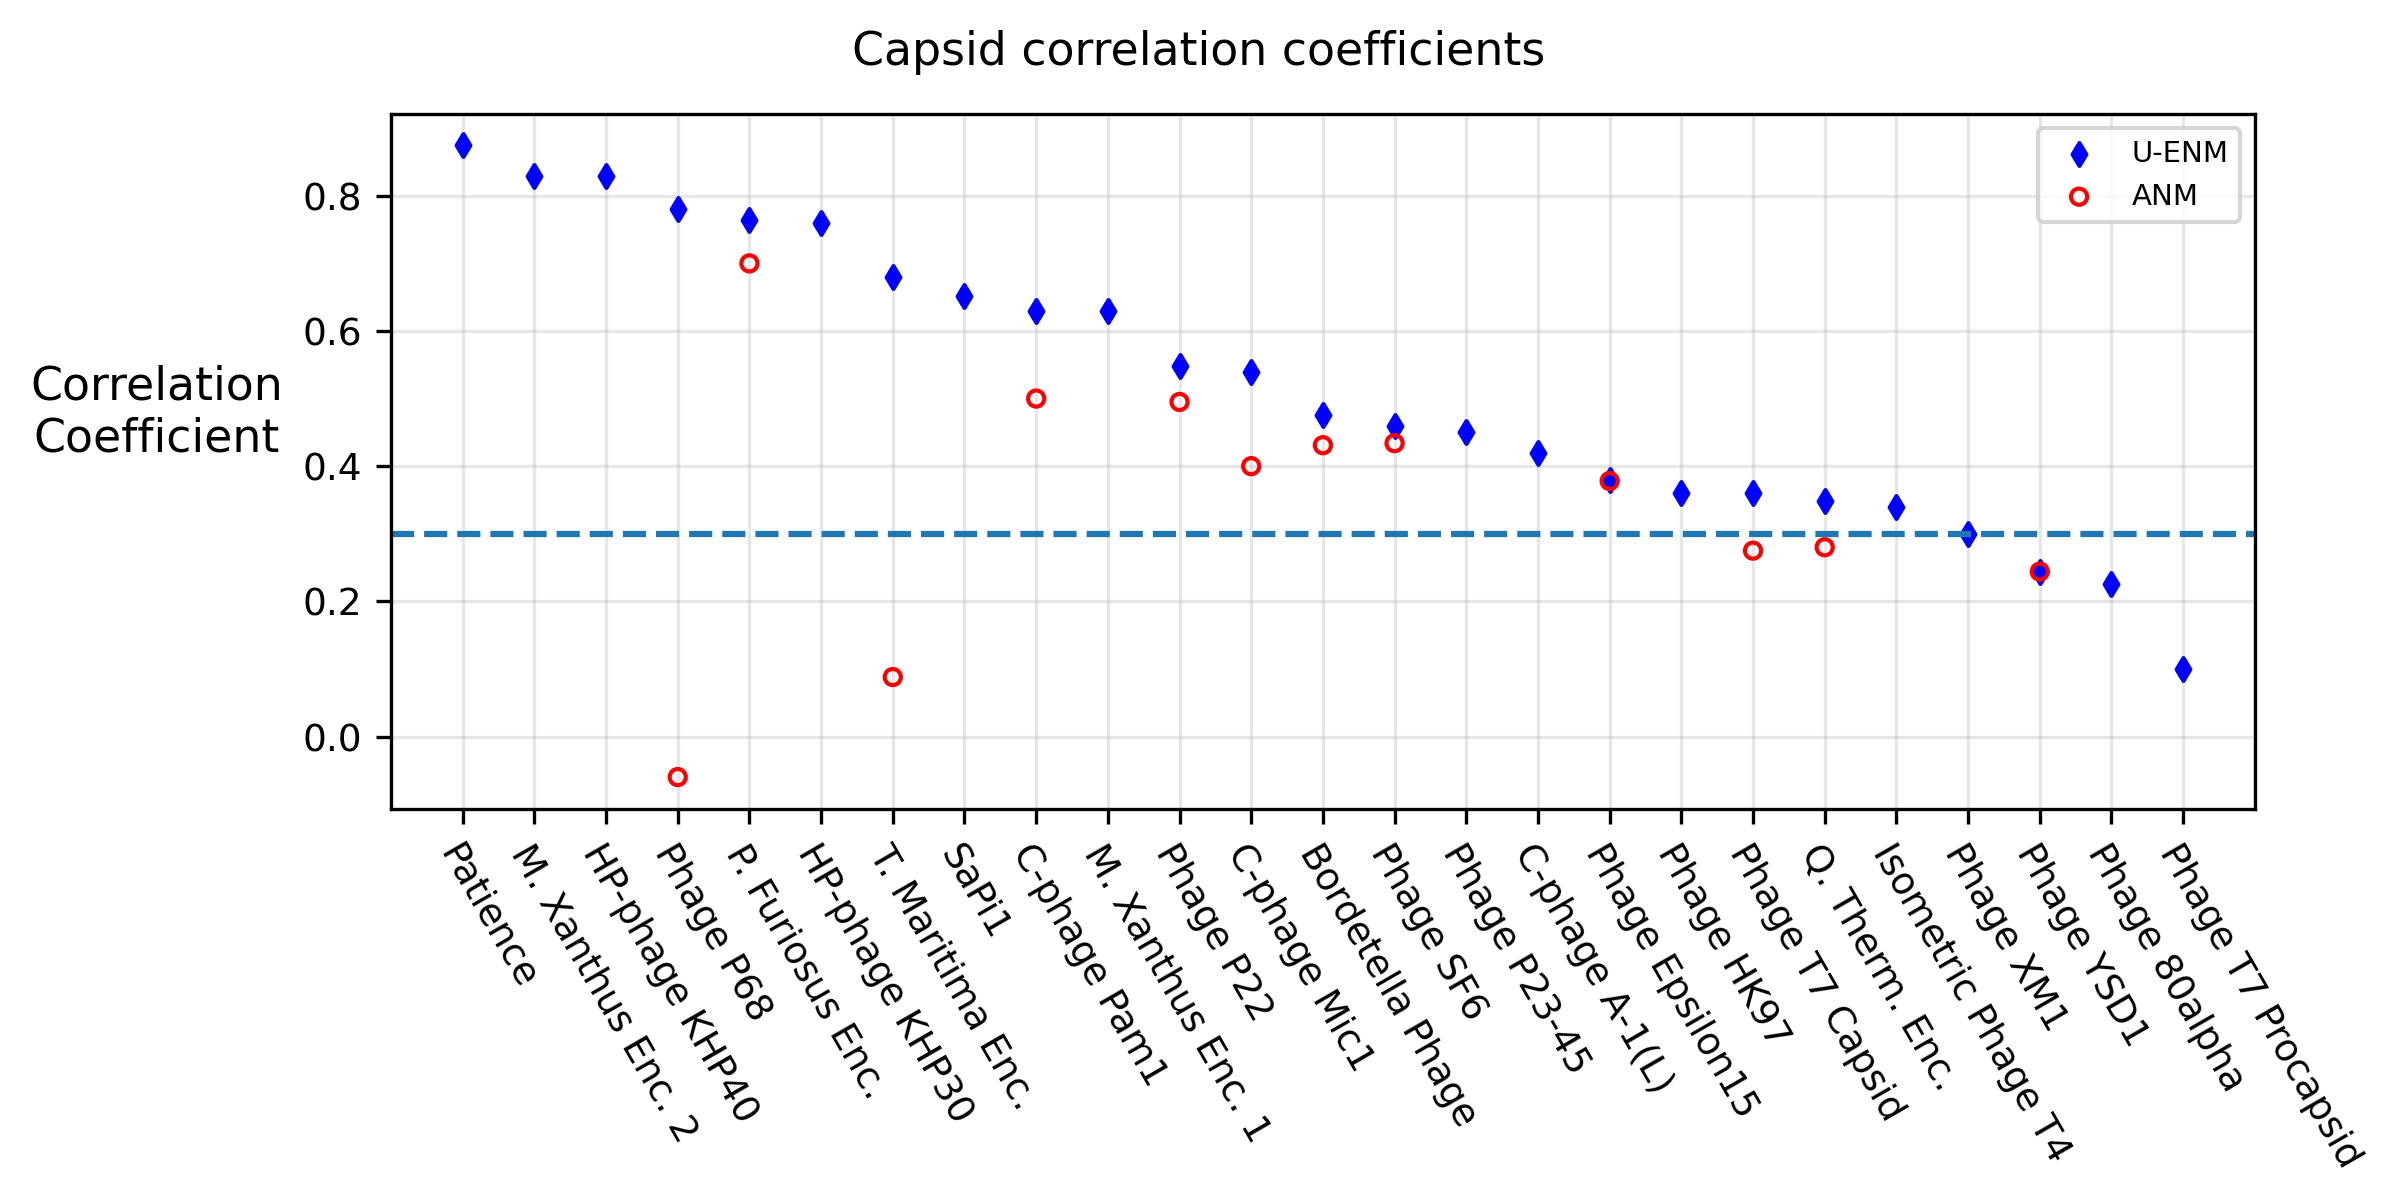

In [97]:
import matplotlib.pyplot as plt
import matplotlib
rs = np.array(table['Residues'])
titles = np.array(table['Abbreviation'])
CCs = np.array(table['CC'])
CCs0 = np.array(table['CCanm'])
CCsb = np.array(table['CCbgnm'])
csort = np.argsort(CCs)[::-1]
CCs = CCs[csort]
CCs0 = CCs0[csort]
CCsb = CCsb[csort]
titles = titles[csort]
ind = np.arange(CCs.shape[0])

print('mean CC: ', CCs.mean())
print('stdev CC: ', CCs.std())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg')
matplotlib.rcParams['figure.dpi'] = 300
ax.set_axisbelow(True)
ax.grid(alpha=0.3)

ax.scatter(ind, CCs, marker = 'd', color='blue', label='U-ENM', s=15)
ax.scatter(ind, CCs0, marker = 'o', color='red', facecolors='none', label='ANM', s=15)
# ax.scatter(ind, CCsb, marker = 'd', color='red', facecolors='none', label='beta-GNM')

ax.hlines(0.3, -1, CCs.shape[0], linestyles='dashed')
#ax.hlines(0, -1, CCs.shape[0], color='black')

ax.set_ylabel('Correlation\nCoefficient', fontsize=11, rotation=0, labelpad=35)
#ax.set_xlabel('PDB ID', fontsize=11, labelpad=-20)
plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.xaxis.set_tick_params(which='minor', pad=5)
#ax.set_ylim([0,1])
ax.set_xlim([-1,CCs.shape[0]])
ax.legend(loc='upper right')
fig.suptitle('Capsid correlation coefficients', fontsize=11)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/correlations_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/correlations_final.svg')

plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.2417
Date:                Mon, 10 Oct 2022   Prob (F-statistic):              0.628
Time:                        06:12:06   Log-Likelihood:                 3.5597
No. Observations:                  25   AIC:                            -3.119
Df Residuals:                      23   BIC:                           -0.6816
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.223e-07   4.52e-07     -0.492      0.6

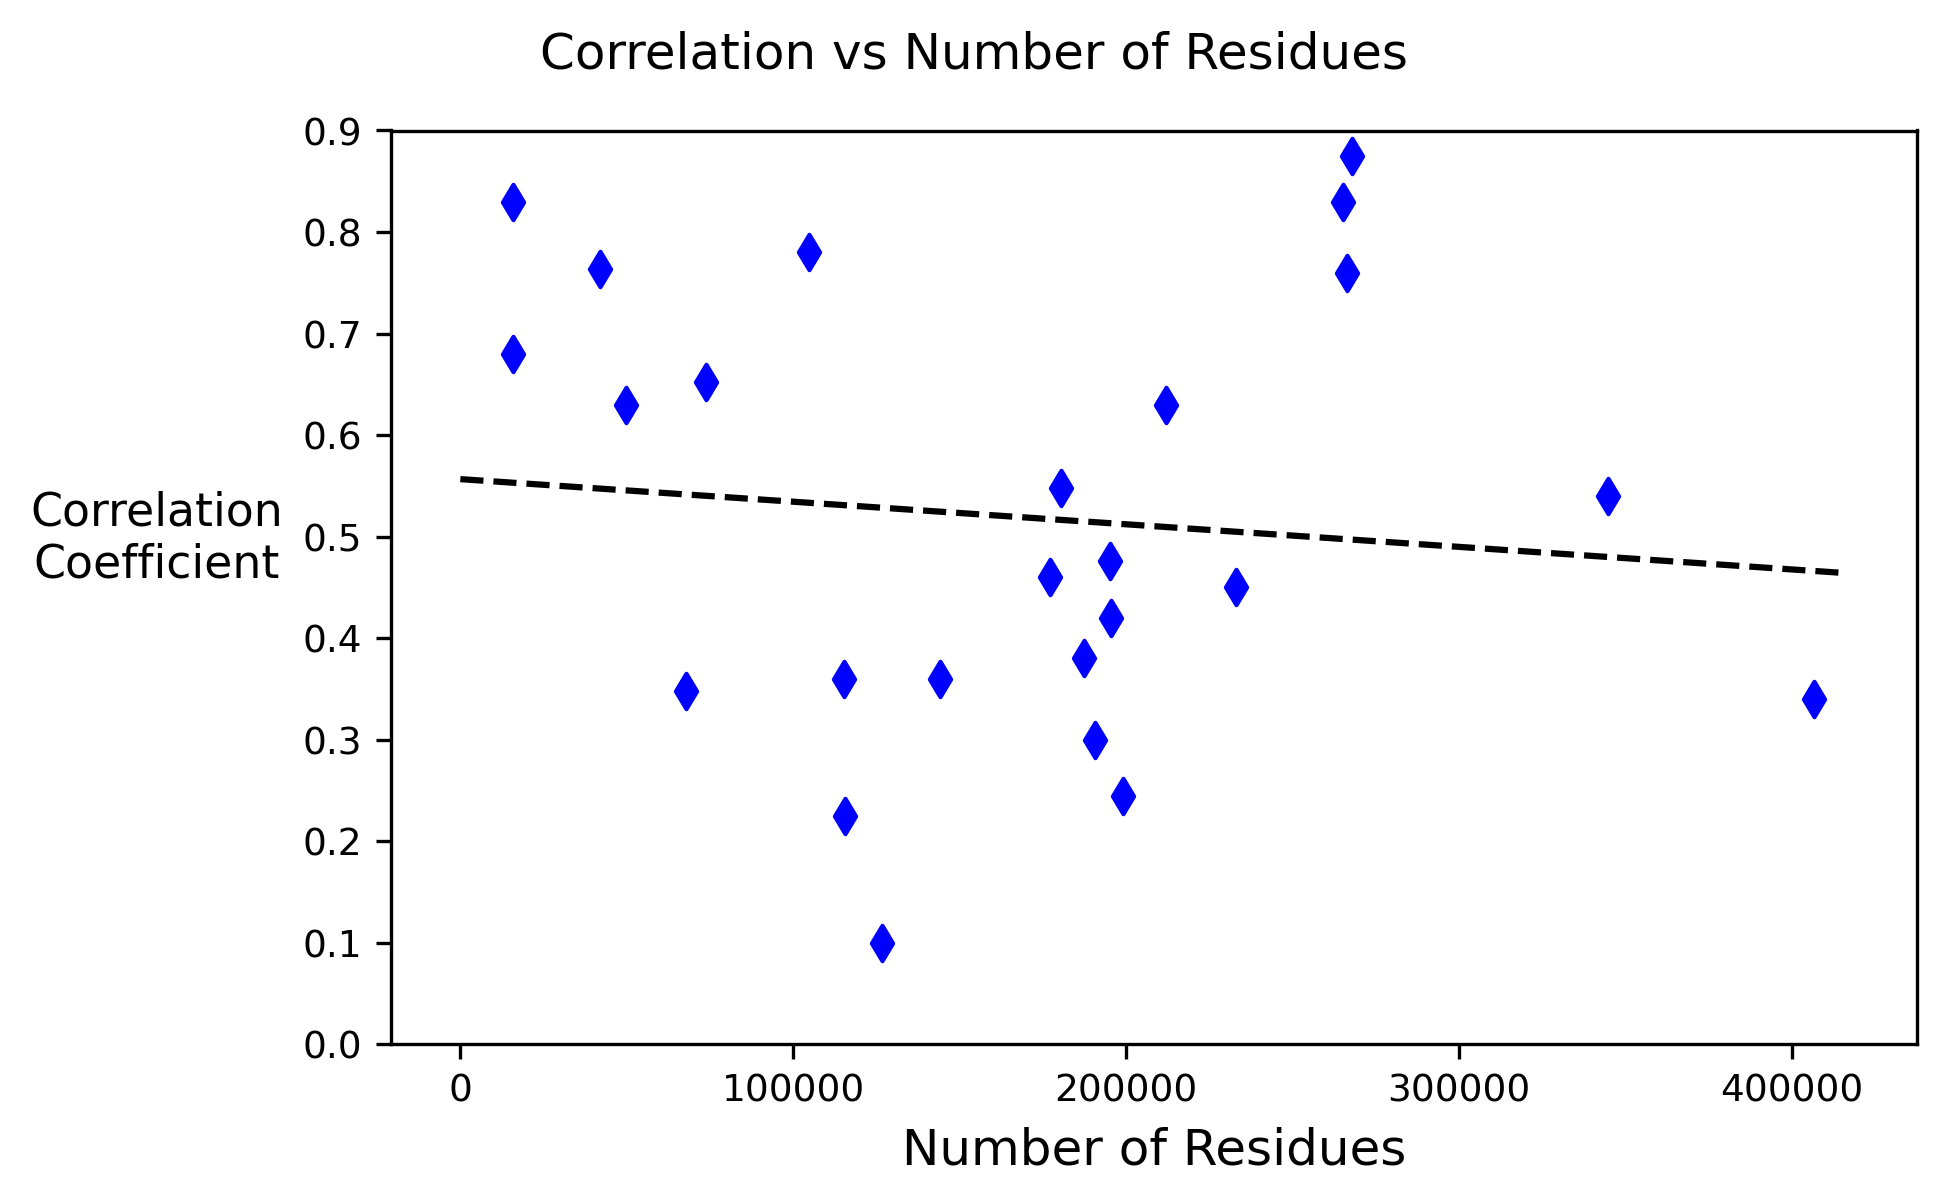

In [98]:
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
res = np.array(table['Residues'])
CCs = np.array(table['CC'])

A = np.vstack((res, np.ones_like(res))).T
model = sm.OLS(CCs,A)
results = model.fit()
print(results.summary())
params = results.params
r2 = results.rsquared
stderr = results.bse
pv = results.pvalues


print('SSR: ', residuals)
print('slope: ', params)
print('r2: ', r2)
print('p-value: ', pv)
print('stderr: ', stderr)

print('params: ', params)
print('residuals: ',residuals)
print('CC variance: ', np.var(CCs))
print('slope: ', params)
print('r2: ', r2)

poly = np.poly1d(params)
x = np.linspace(0,np.max(res) + 10000)


fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.plot(x, poly(x), '--', label='Linear Fit', color='black' )
ax.scatter(res, CCs, marker = 'd', color='blue', label='U-ENM')

ax.set_ylabel('Correlation\nCoefficient', fontsize=11, rotation=0, labelpad=35)
ax.set_xlabel('Number of Residues', fontsize=12)
#plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.xaxis.set_tick_params(which='minor', pad=5)
ax.set_ylim([0,0.9])
#ax.set_xlim([-1,CCs.shape[0]-9.5])
#ax.legend()

fig.suptitle('Correlation vs Number of Residues', fontsize=12)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/residues_CC_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/residues_CC_final.svg')

### Correlation vs Resolution

0.875
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     16.56
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           0.000474
Time:                        06:12:24   Log-Likelihood:                 10.208
No. Observations:                  25   AIC:                            -16.42
Df Residuals:                      23   BIC:                            -13.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2089      0.051     -4.069   

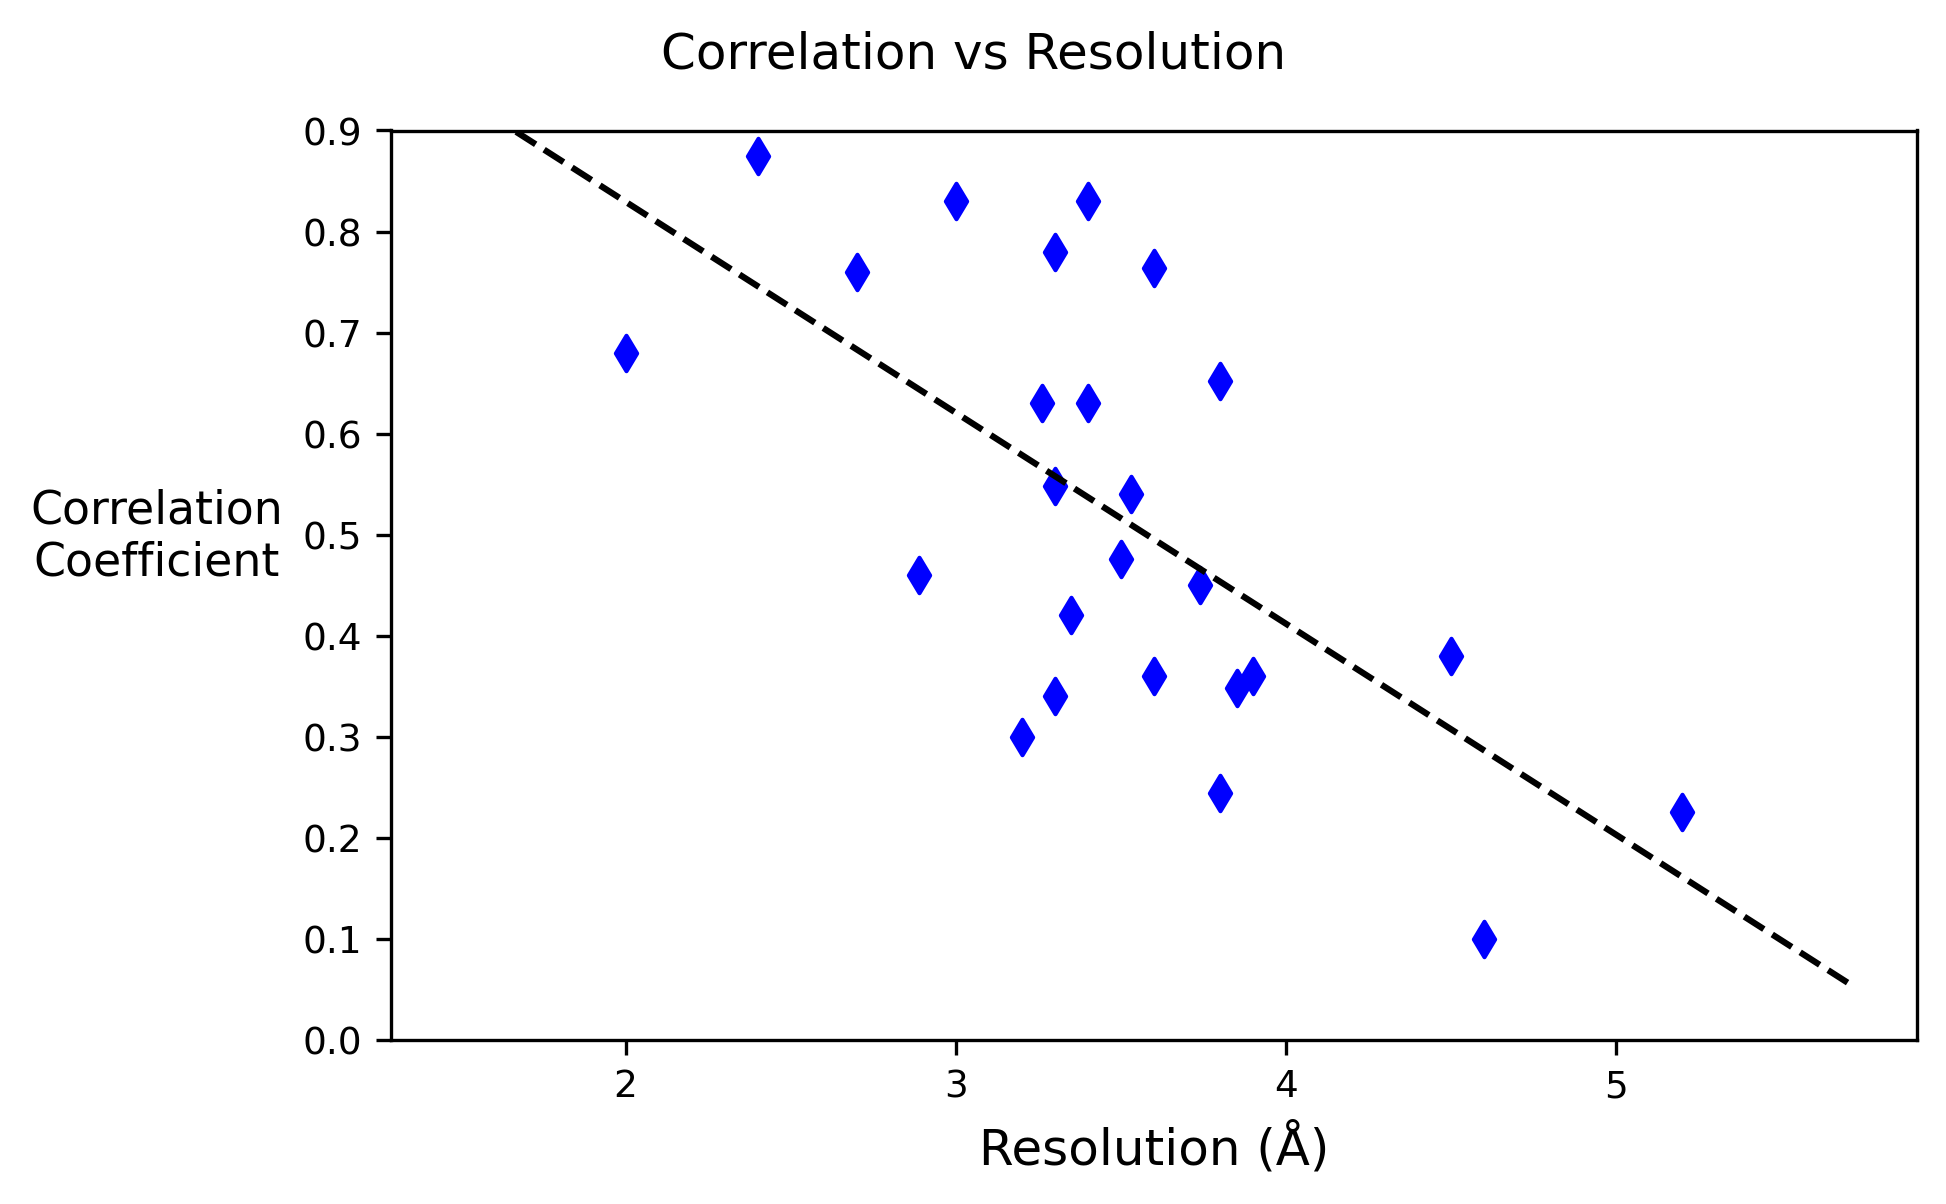

In [99]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
res = np.array(table['Resolution'])
CCs = np.array(table['CC'])
print(CCs.max())

A = np.vstack((res, np.ones_like(res))).T

model = sm.OLS(CCs,A)
results = model.fit()
print(results.summary())
params = results.params
r2 = results.rsquared
stderr = results.bse
pv = results.pvalues


print('SSR: ', residuals)
print('slope: ', params)
print('r2: ', r2)
print('p-value: ', pv)
print('stderr: ', stderr)

print('params: ', params)
print('residuals: ',residuals)
print('CC variance: ', np.var(CCs))
print('slope: ', params)
print('r2: ', r2)

poly = np.poly1d(params)
x = np.linspace(np.min(res)-0.5,np.max(res) + 1/2)

fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.plot(x, poly(x), '--', label='Linear Fit', color='black' )
ax.scatter(res, CCs, marker = 'd', color='blue', label='U-ENM')

ax.set_ylabel('Correlation\nCoefficient', fontsize=11, rotation=0, labelpad=35)
ax.set_xlabel('Resolution (Å)', fontsize=12)
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.xaxis.set_tick_params(which='minor', pad=5)
ax.set_ylim([0,0.9])
#ax.set_xlim([-1,CCs.shape[0]-9.5])
#ax.legend()

fig.suptitle('Correlation vs Resolution', fontsize=12)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/CC_vs_res_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/CC_vs_res_final.svg')

### B-ENM Correlations

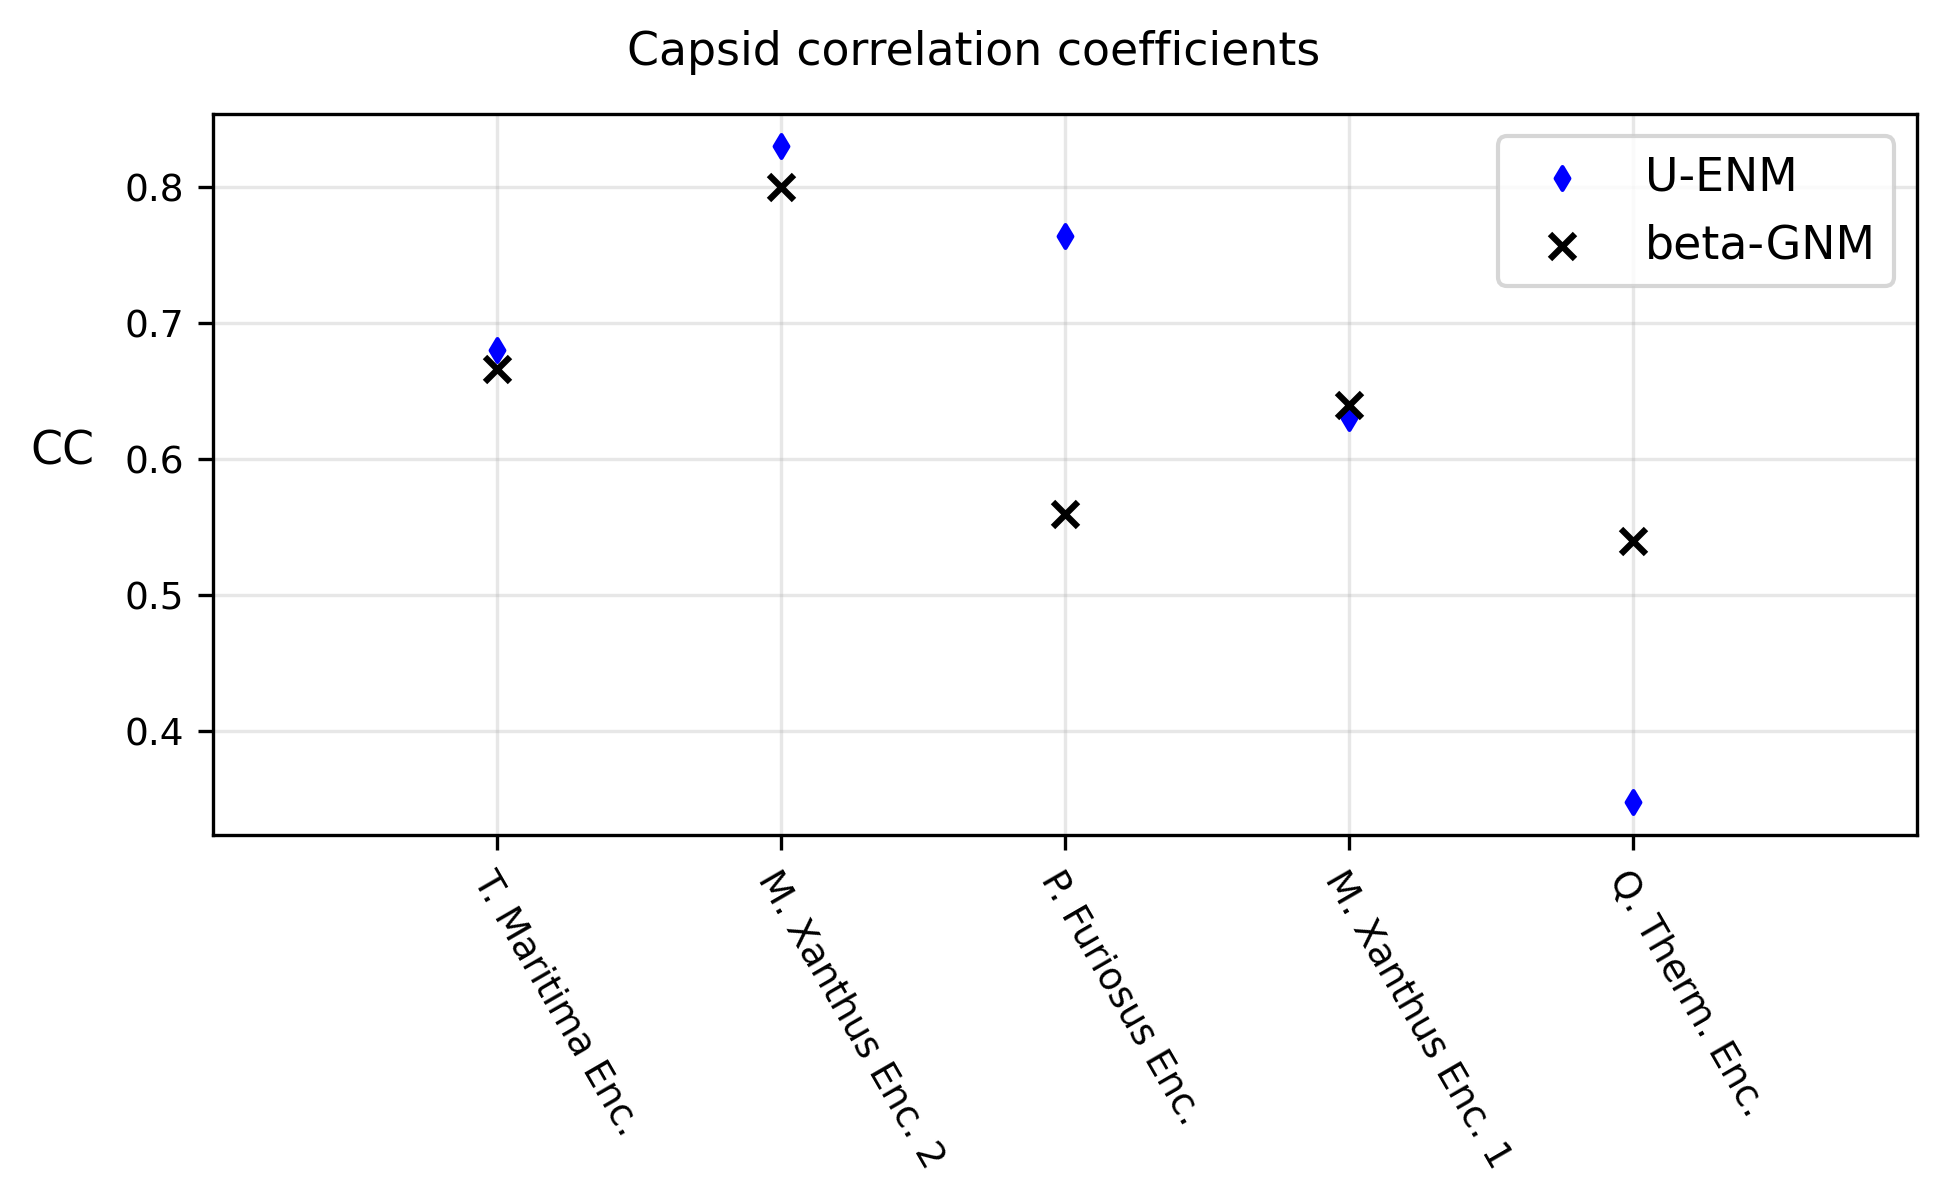

In [68]:
import matplotlib.pyplot as plt
import matplotlib
rs = np.array(table['Residues'])
titles = np.array(table['Abbreviation'])
CCs = np.array(table['CC'])
CCs0 = np.array(table['CCanm'])
CCsb = np.array(table['CCbgnm'])
bmask = ~np.isnan(CCsb)
CCs = CCs[bmask]
CCs0 = CCs0[bmask]
CCsb = CCsb[bmask]
titles = titles[bmask]
rs = rs[bmask]
csort = np.argsort(rs)
CCs = CCs[csort]
CCs0 = CCs0[csort]
CCsb = CCsb[csort]
titles = titles[csort]
ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')
matplotlib.rcParams['figure.dpi'] = 300
ax.set_axisbelow(True)
ax.grid(alpha=0.3)

ax.scatter(ind, CCs, marker = 'd', color='blue', label='U-ENM', s=15)
#ax.scatter(ind, CCs0, marker = 'o', color='red', facecolors='none', label='ANM', s=15)
ax.scatter(ind, CCsb, marker = 'x', color='black', label='beta-GNM')


ax.set_ylabel('CC', fontsize=11, rotation=0, labelpad=15)
#ax.set_xlabel('PDB ID', fontsize=11, labelpad=5)
plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
ax.xaxis.set_tick_params(which='minor', pad=5)
#ax.set_ylim([0,1])
ax.set_xlim([-1,CCs.shape[0]])
ax.legend(loc='upper right', fontsize=11)
fig.suptitle('Capsid correlation coefficients', fontsize=11)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/correlations_bgm_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/correlations_figs/correlations_bgm_final.svg')

plt.show()

## Spring Constant Results

mean spring constant:  5.887619047619047
stdev spring constant:  6.2982702876885215
mean compressibility:  392.81428571428575
stdev compressibility:  316.0403670505434


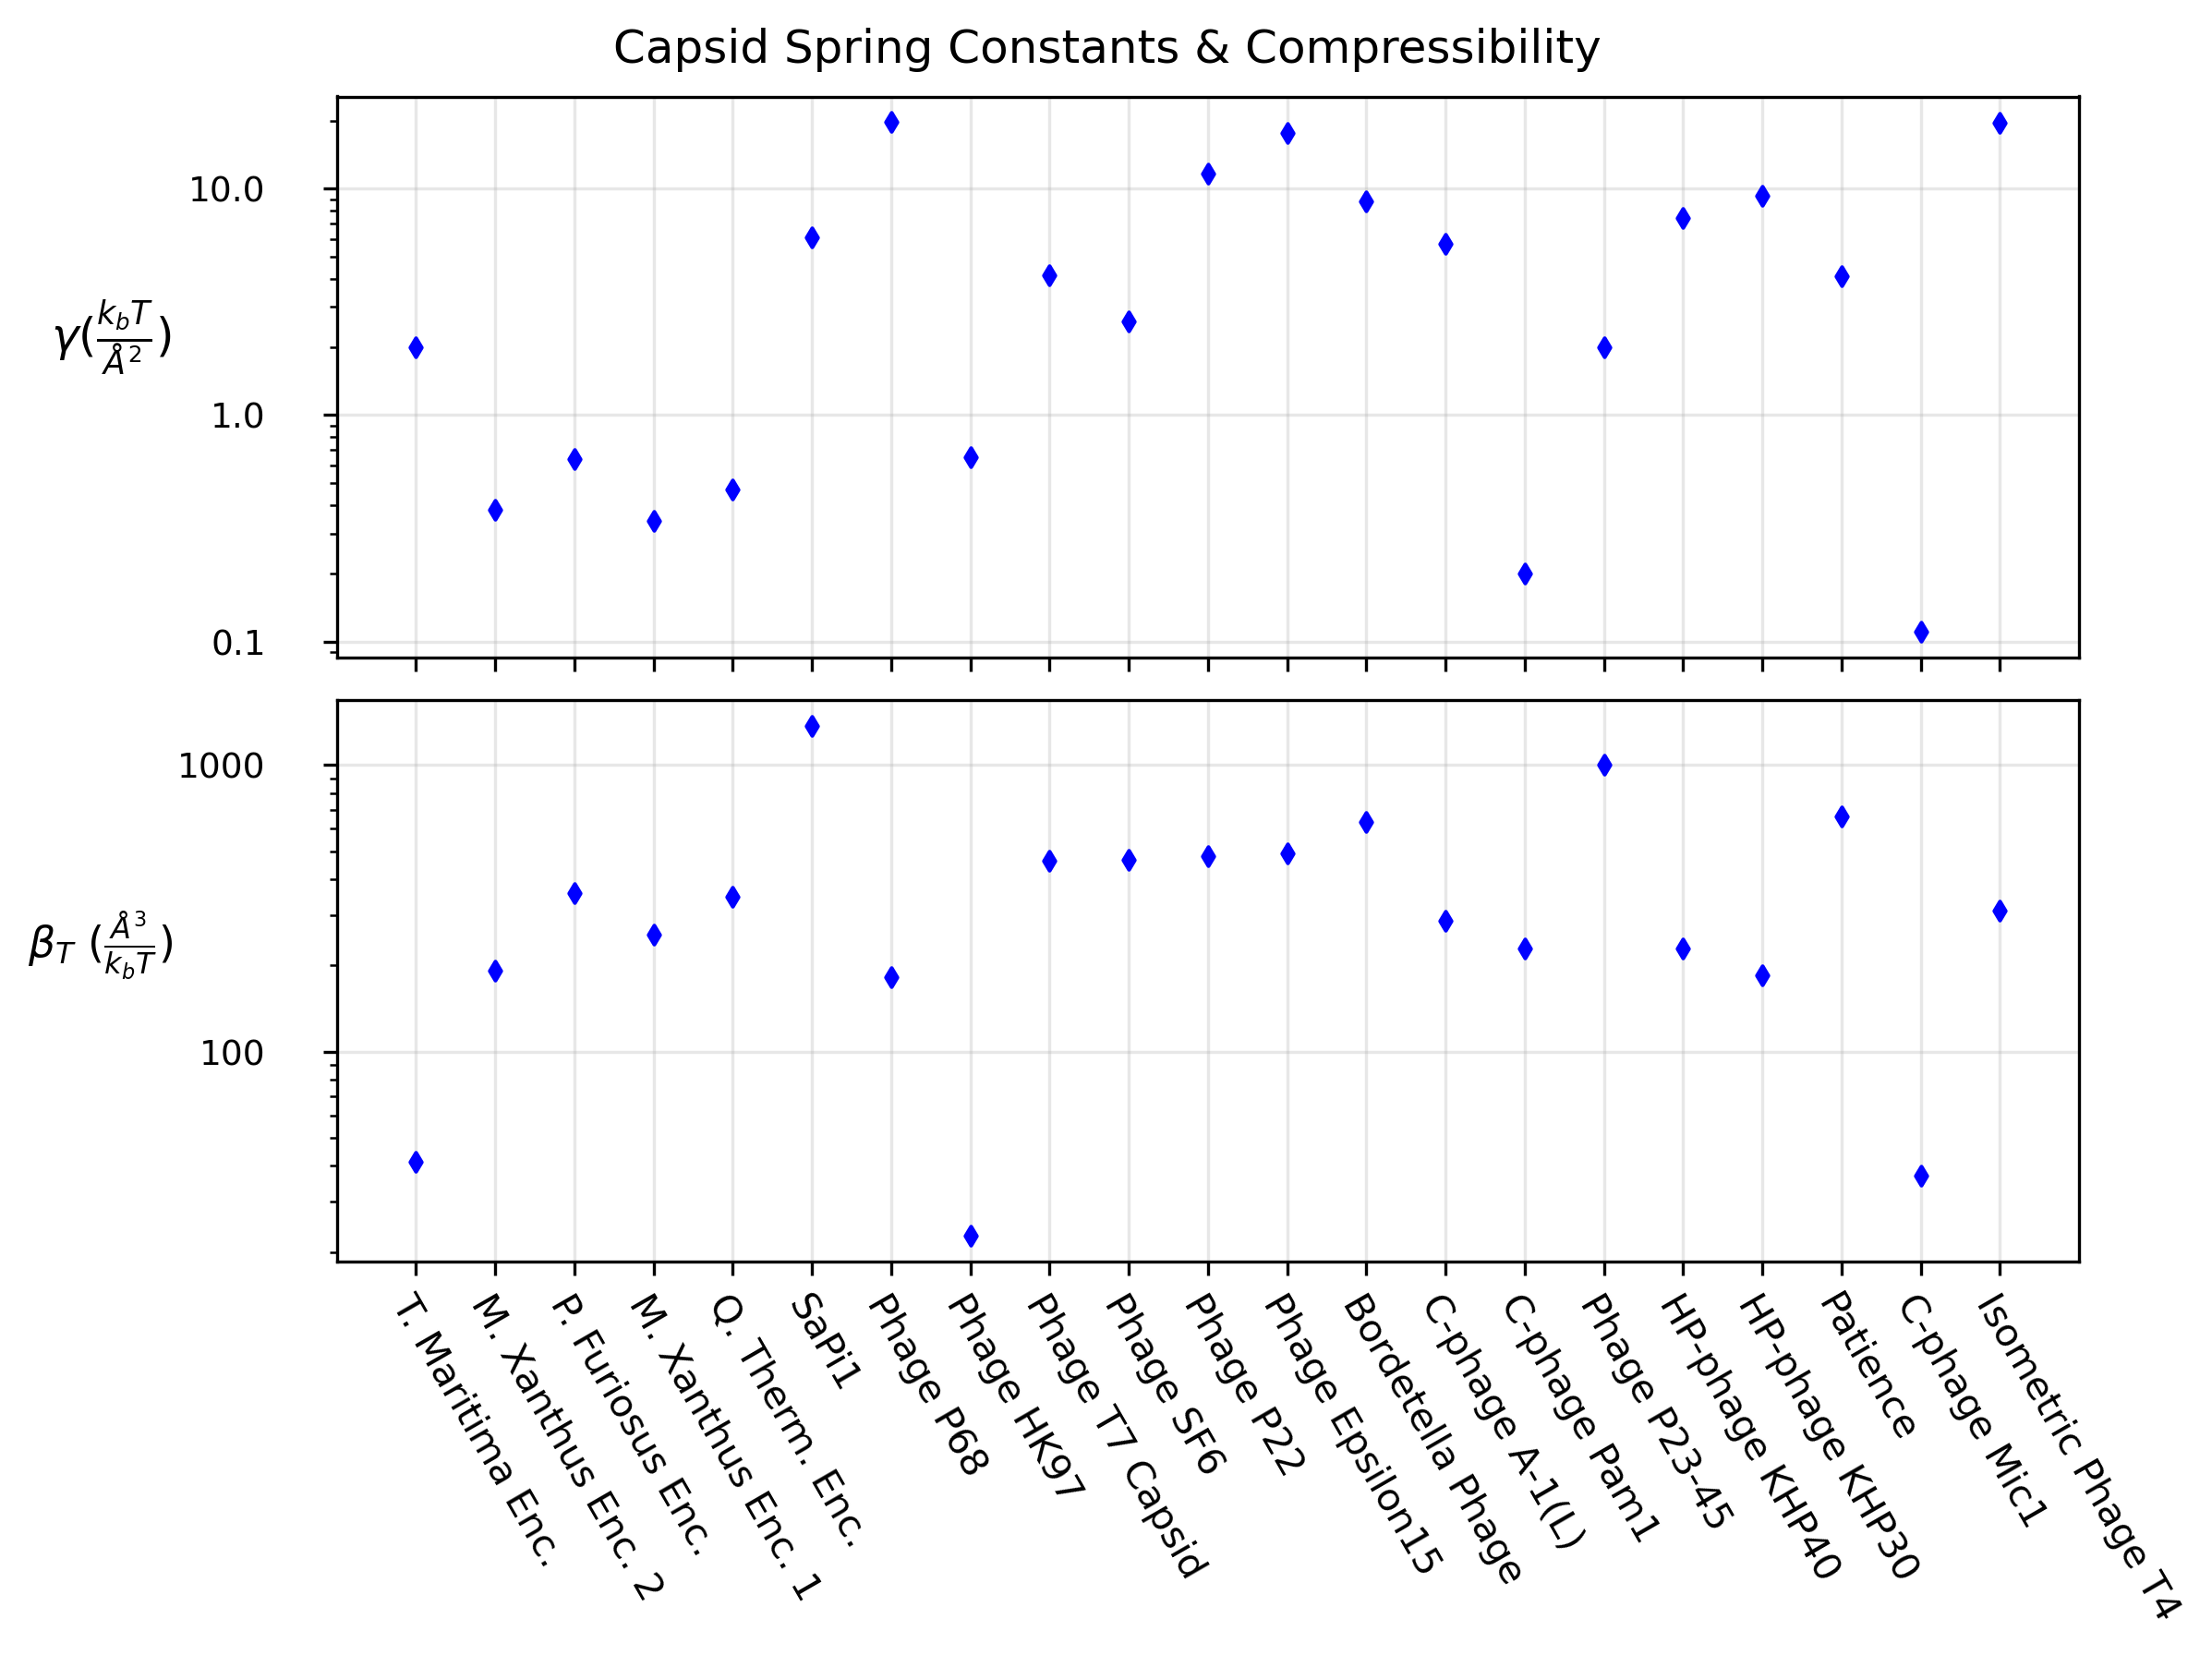

In [100]:
import matplotlib.pyplot as plt
import matplotlib

rs = np.array(table['Residues'])
titles = np.array(table['Abbreviation'])
gammas = np.array(table['Spring Constant'])
bm = np.array(table['Compressibility'])
CCs = np.array(table['CC'])

cmask = CCs > 0.3
rs = rs[cmask]
titles = titles[cmask]
gammas = gammas[cmask]
bm = bm[cmask]
csort = np.argsort(rs)
gammas = gammas[csort]
titles = titles[csort]
bm = bm[csort]

print('mean spring constant: ', np.mean(gammas))
print('stdev spring constant: ', np.std(gammas))

print('mean compressibility: ', np.mean(bm))
print('stdev compressibility: ', np.std(bm))

#titles = titles[csort]
ind = np.arange(titles.shape[0])

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.set_axisbelow(True)
ax.grid(alpha=0.3)
ax2.set_axisbelow(True)
ax2.grid(alpha=0.3)


ax.scatter(ind, gammas, marker = 'd', color='blue', s=12)
ax2.scatter(ind, bm, marker = 'd', color='blue', label='U-ENM', s=12)

ax.set_yscale('log')
ax2.set_yscale('log')
# ax.yaxis.set_tick_params(which='minor')
# ax2.yaxis.set_tick_params(which='minor')


from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
# ax2.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))


ax.set_ylabel(r'$\gamma (\frac{k_b T}{Å^2})$', fontsize=12, rotation=0, labelpad=20)
ax2.set_ylabel(r'$\beta_T$' + ' ' + r'$(\frac{Å^3}{k_b T})$', fontsize=11, rotation=0, labelpad=20)
plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')

ax.tick_params(axis='y', labelsize=9, pad=15)
ax2.tick_params(axis='y', labelsize=9, pad=15)

ax2.tick_params(axis='x', labelsize=10)
ax.xaxis.set_tick_params(which='minor', pad=5)

fig.suptitle('Capsid Spring Constants & Compressibility', fontsize=12)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/mech_features_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/mech_features_final.svg')

plt.show()

 ## Rigid Clusters Results

### # of Clusters by Capsid

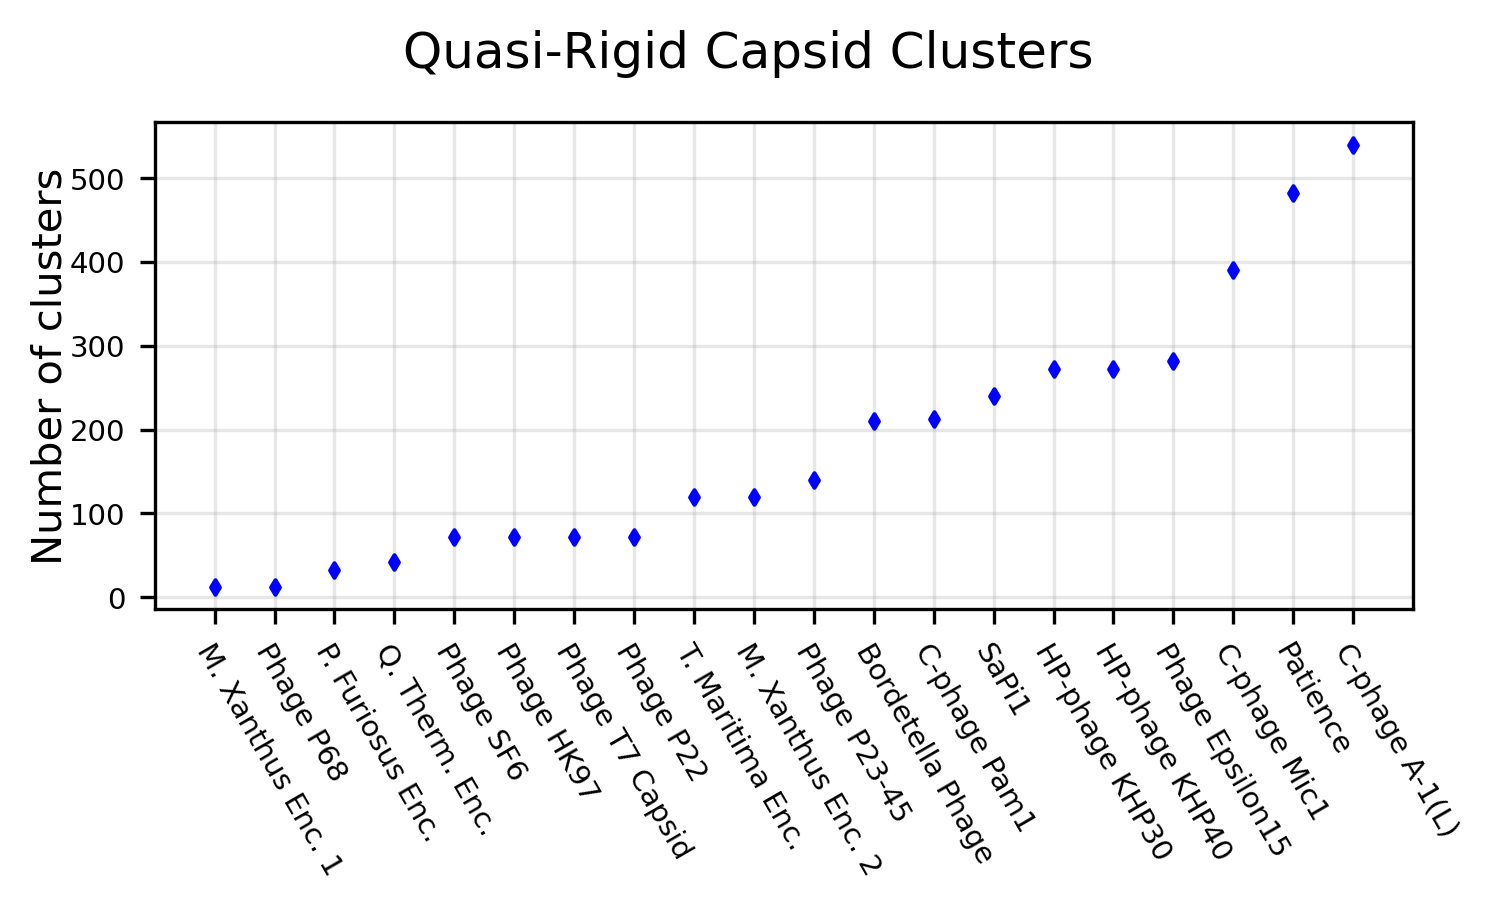

In [177]:
import matplotlib.pyplot as plt
import matplotlib
rs = np.array(table['Residues'])
titles = np.array(table['Abbreviation'])
clusters = np.array(table['Clusters'])
CCs = np.array(table['CC'])
cmask = CCs > 0.3
rs = rs[cmask]
titles = titles[cmask]
clusters = clusters[cmask]
csort = np.argsort(clusters)
clusters = clusters[csort]
titles = titles[csort]

#titles = titles[csort]
ind = np.arange(titles.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')
ax.set_axisbelow(True)
ax.grid(alpha=0.3)


ax.scatter(ind, clusters, marker = 'd', color='blue', label='U-ENM', s=6)
# ax.scatter(ind, CCs0, marker = 'o', color='blue', facecolors='none', label='ANM')
# ax.scatter(ind, CCsb, marker = 'd', color='red', facecolors='none', label='beta-GNM')


ax.set_ylabel('Number of clusters', fontsize=10, labelpad=0)
#ax.set_xlabel('Capsid', fontsize=9, labelpad=-20)
plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=7)
ax.xaxis.set_tick_params(which='minor', pad=5)
#ax.set_ylim([0,1])
ax.set_xlim([-1,rs.shape[0]])
#ax.legend()
fig.suptitle('Quasi-Rigid Capsid Clusters', fontsize=12)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/clusters_pdb_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/clusters_pdb_final.svg')
plt.show()

### Cluster quality by capsid

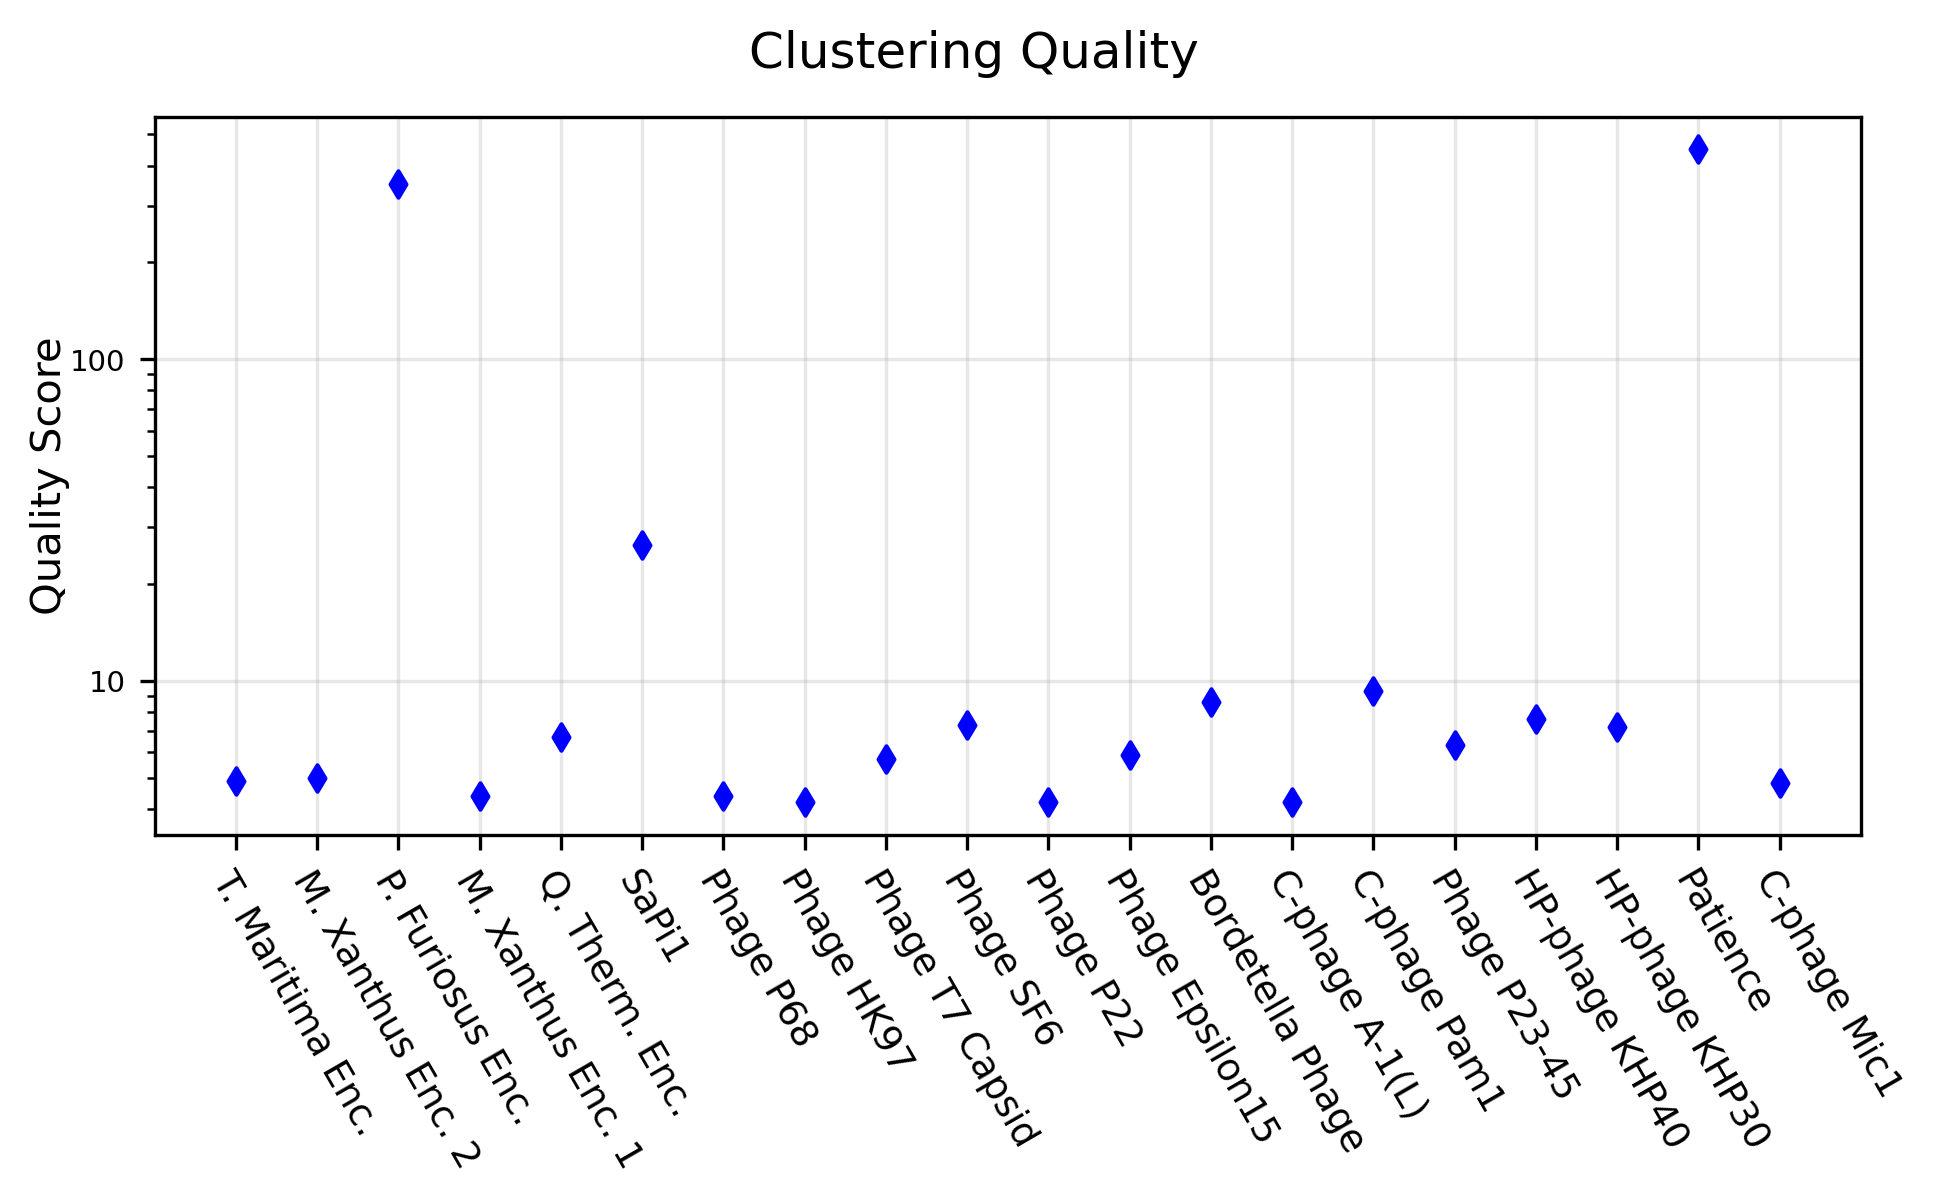

In [179]:
import matplotlib.pyplot as plt
import matplotlib
rs = np.array(table['Residues'])
titles = np.array(table['Abbreviation'])
score = np.array(table['Quality'])
CCs = np.array(table['CC'])
cmask = CCs > 0.3
rs = rs[cmask]
titles = titles[cmask]
score = score[cmask]
csort = np.argsort(rs)
score = score[csort]
titles = titles[csort]

#titles = titles[csort]
ind = np.arange(titles.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.scatter(ind, score, marker = 'd', color='blue', label='U-ENM', s=20)
# ax.scatter(ind, CCs0, marker = 'o', color='blue', facecolors='none', label='ANM')
# ax.scatter(ind, CCsb, marker = 'd', color='red', facecolors='none', label='beta-GNM')
plt.yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_ylabel('Quality Score', fontsize=10, labelpad=0)
plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=9)
ax.xaxis.set_tick_params(which='minor', pad=5)

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

#ax.set_ylim([0,1])
ax.set_xlim([-1,rs.shape[0]])
#ax.legend()
fig.suptitle('Clustering Quality', fontsize=12)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/cluster_score_final.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/cluster_score_final.svg')
plt.show()

### Combined

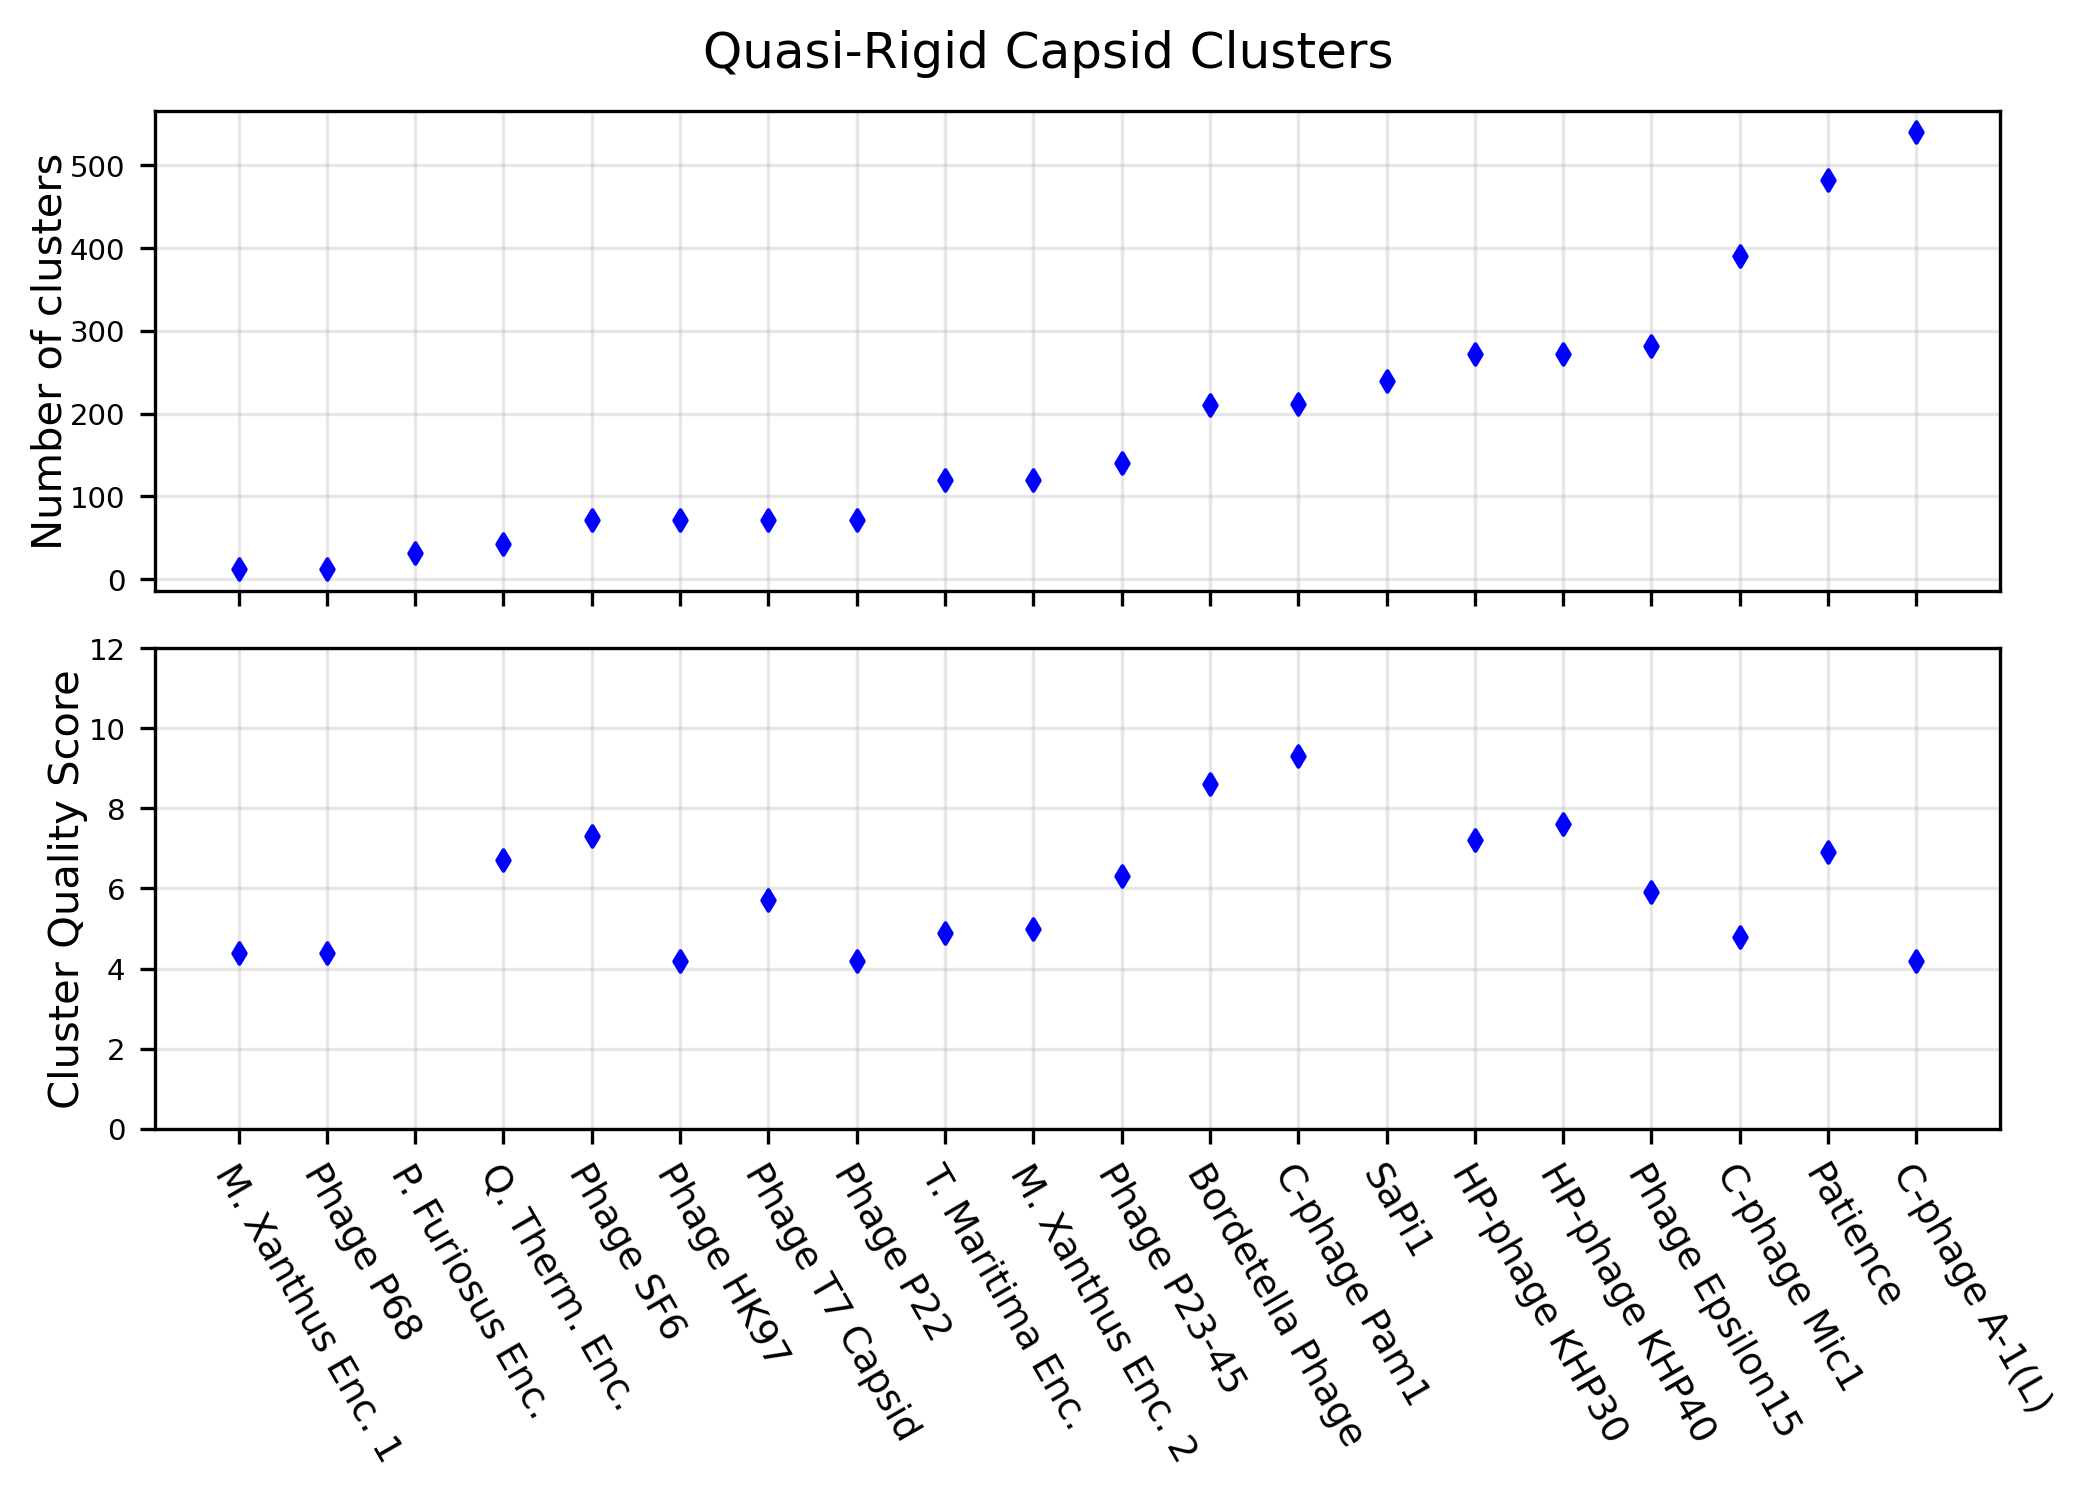

In [211]:
import matplotlib.pyplot as plt
import matplotlib
titles = np.array(table['Abbreviation'])
clusters = np.array(table['Clusters'])
score = np.array(table['Quality'])
CCs = np.array(table['CC'])

cmask = CCs > 0.3
titles = titles[cmask]
clusters = clusters[cmask]
score = score[cmask]

csort = np.argsort(clusters)
clusters = clusters[csort]
titles = titles[csort]
score = score[csort]

#titles = titles[csort]
ind = np.arange(titles.shape[0])

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')
ax.set_axisbelow(True)
ax.grid(alpha=0.3)
ax2.set_axisbelow(True)
ax2.grid(alpha=0.3)


ax.scatter(ind, clusters, marker = 'd', color='blue', label='U-ENM', s=12)
ax2.scatter(ind, score, marker = 'd', color='blue', label='U-ENM', s=12)

# ax2.set_yscale('log')
ax2.set_ylim([0,12])

ax.set_ylabel('Number of clusters', fontsize=10, labelpad=0)
ax2.set_ylabel('Cluster Quality Score', fontsize=10, labelpad=0)

plt.xticks(ind, labels=titles, rotation = -60, ha='left', rotation_mode='anchor')

ax.tick_params(axis='y', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.tick_params(axis='x', labelsize=9)
ax2.xaxis.set_tick_params(which='minor', pad=5)

fig.suptitle('Quasi-Rigid Capsid Clusters', fontsize=12)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/clusters_pdb_combined.png')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/clusters_pdb_combined.svg')
plt.show()

### Clusters vs Residues

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.823
Model:                            OLS   Adj. R-squared (uncentered):              0.816
Method:                 Least Squares   F-statistic:                              111.9
Date:                Mon, 10 Oct 2022   Prob (F-statistic):                    1.62e-10
Time:                        06:32:48   Log-Likelihood:                         -151.26
No. Observations:                  25   AIC:                                      304.5
Df Residuals:                      24   BIC:                                      305.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

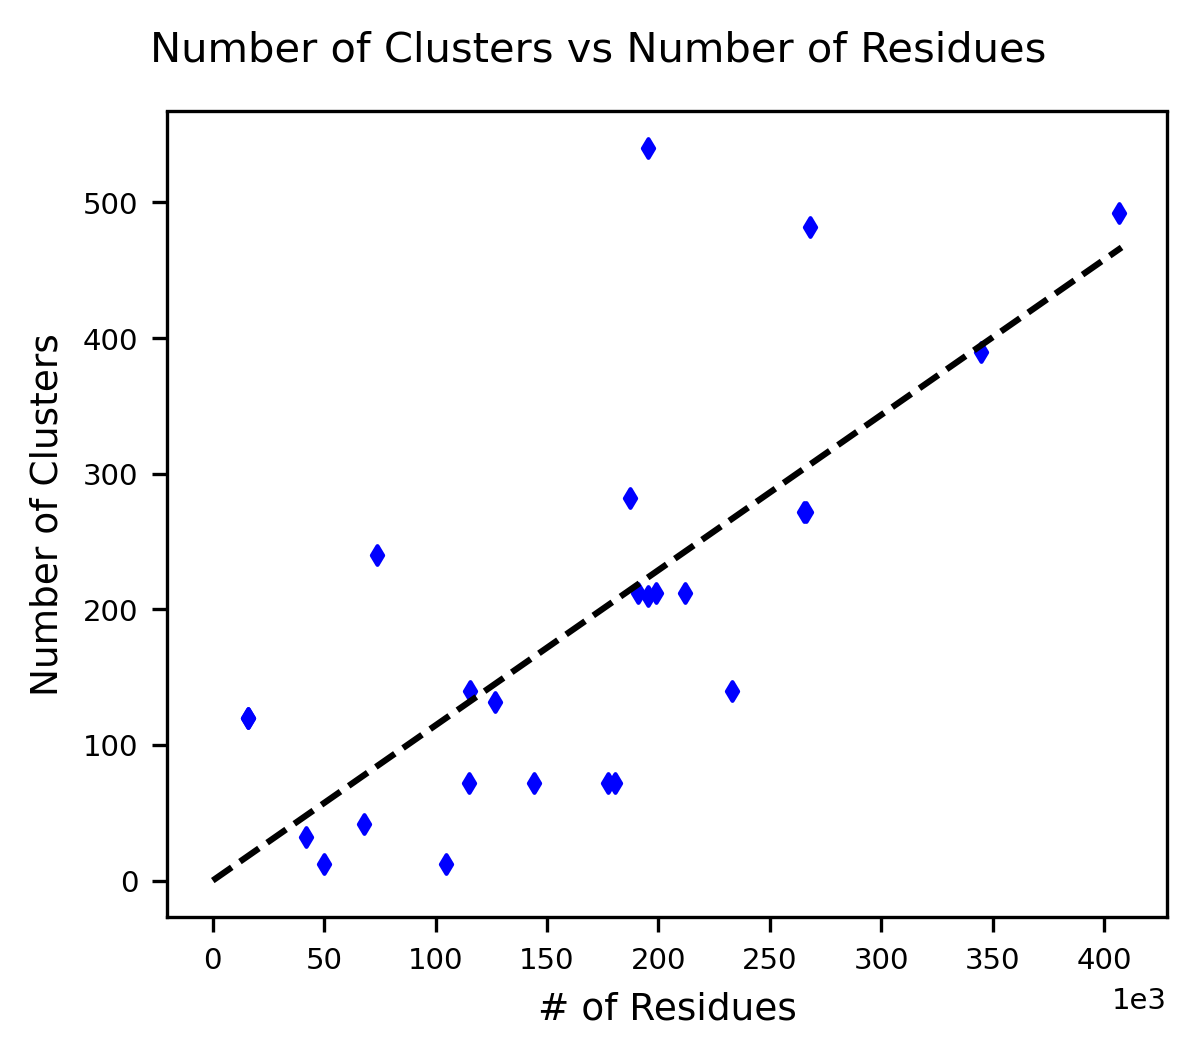

In [108]:
import matplotlib.pyplot as plt
import matplotlib
residues = np.array(table['Residues'])
n_clusts = np.array(table['Clusters'])
ind = np.arange(residues.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

#A = np.vstack((residues)).T

model = sm.OLS(n_clusts,residues)
results = model.fit()
print(results.summary())
params = results.params
r2 = results.rsquared
stderr = results.bse
pv = results.pvalues


print('SSR: ', residuals)
print('slope: ', params)
print('r2: ', r2)
print('p-value: ', pv)
print('stderr: ', stderr)

print('params: ', params)
print('residuals: ',residuals)
print('nc variance: ', np.var(n_clusts))
print('slope: ', params)
print('r2: ', r2)

x = np.arange(np.max(residues)+1000)
poly = np.poly1d([params[0],0])

ax.scatter(residues, n_clusts, marker='d', color='blue', s=10)
ax.plot(x, poly(x), '--', label='Linear Fit', color='black' )

ax.set_ylabel('Number of Clusters', fontsize=9)
ax.set_xlabel('# of Residues', fontsize=9)
plt.ticklabel_format(axis='x',style='sci', scilimits=(3,3))
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=7)
fig.suptitle('Number of Clusters vs Number of Residues', fontsize=10)
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/clusters_v_residues_final.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/clusters_v_residues_final.png')
plt.show()

### Clusters by Number Of Proteins

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 60 180 240 420 540 780]
[array([120, 120], dtype=int64), array([32, 12], dtype=int64), array([ 42,  12, 240], dtype=int64), array([210,  72,  72, 140,  72,  72, 282, 482, 212], dtype=int64), array([540, 272, 272], dtype=int64), array([390, 492], dtype=int64)]


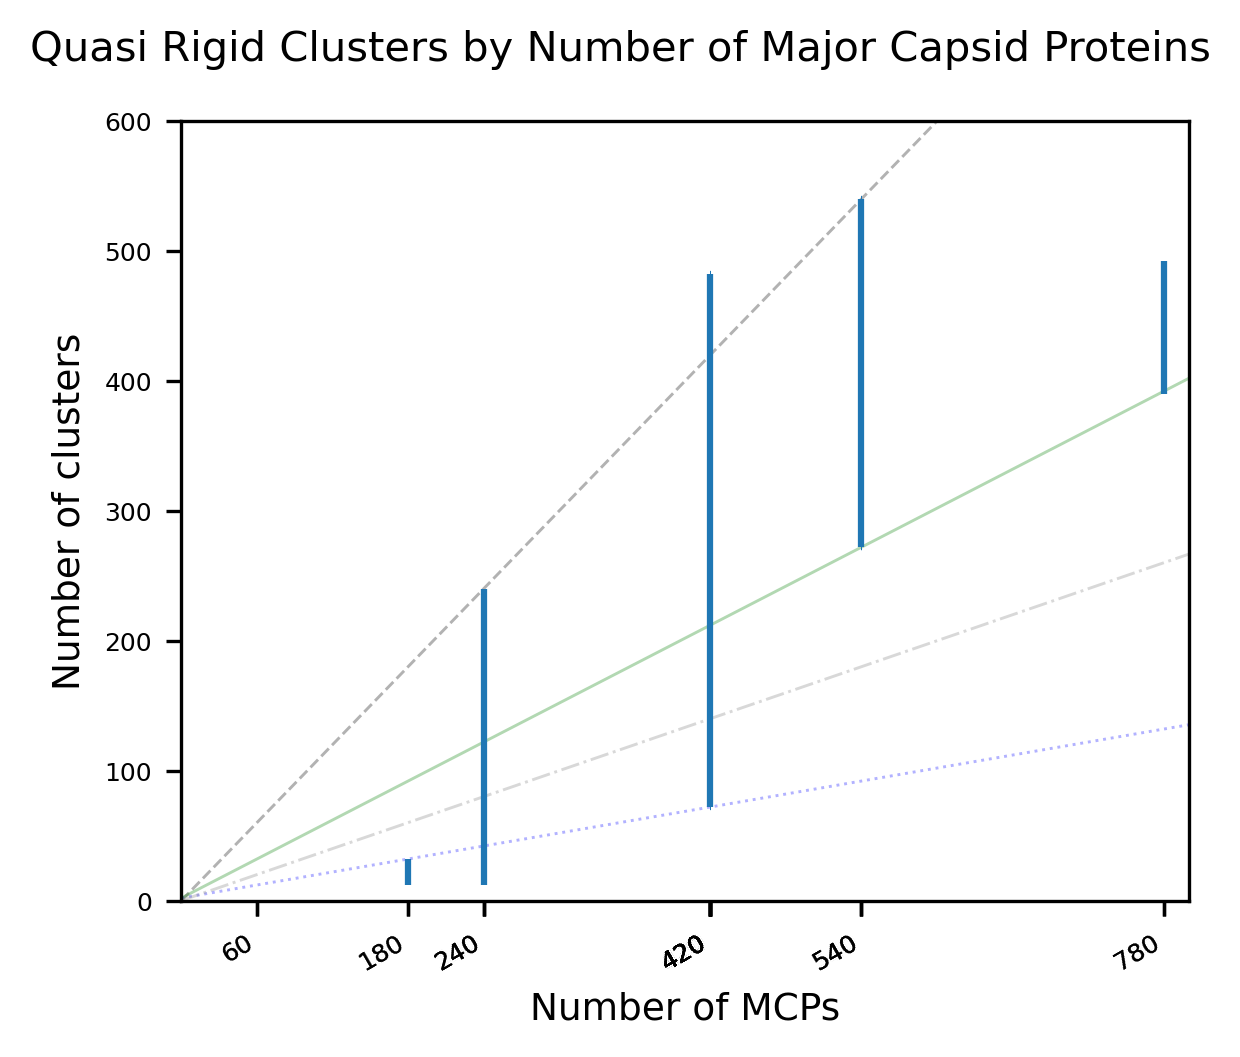

In [26]:
import matplotlib.pyplot as plt
import matplotlib

CCs = np.array(table['CC'])
cmask = CCs > 0.3

reinforcements = table['Reinforcement'][cmask]
p = np.array(table['# of MCPs'])[cmask]
p_nr = p[pd.isnull(reinforcements)]
p_r = p[~pd.isnull(reinforcements)]

n_c = np.array(table['Clusters'])[cmask]
n_c_nr = n_c[pd.isnull(reinforcements)]
n_c_r = n_c[~pd.isnull(reinforcements)]


pos = np.unique(p)
print(pos)
vdata = [n_c[np.where(p==x)] for x in pos]
print(vdata)

ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

#ax.scatter(p_nr, n_c_nr, marker='d', color='blue', s=10, label='No reinforcement proteins', linewidth=0.5, zorder=2)
ax.violinplot(vdata, pos, showmeans=True, showextrema=True, showmedians=True)
#ax.scatter(p_r, n_c_r, marker = 'o', color='red', facecolors='none', s=10, label='Reinforcement proteins', linewidth=0.5, zorder=2)
ax.legend(fontsize=7, frameon=False)

def abline(slope, intercept, color, linestyle):
    """Plot a line from slope and intercept"""
    ax = plt.gca()
    px = np.array(ax.get_xlim())
    py = intercept + slope * px
    ax.plot(px,py, color = color, linestyle=linestyle, linewidth=0.7, zorder=1, alpha=0.3)

ax.set_xlim([0,800])
ax.set_ylim([0,600])


# protein line
abline(1,0, 'black', 'dashed')

# hex line
abline(1/6,2, 'blue', 'dotted')

# hex-dual line
abline(1/3,0, 'grey', 'dashdot')

# trihex line
abline(1/2,2, 'green', 'solid')

ax.set_ylabel('Number of clusters', fontsize=9)
ax.set_xlabel('Number of MCPs', fontsize=9)
ax.set_xticks(p)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='x', labelsize=6)
fig.suptitle('Quasi Rigid Clusters by Number of Major Capsid Proteins', fontsize=10)
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/nmcp_clusters_final.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/nmcp_clusters_final.png')
plt.show()

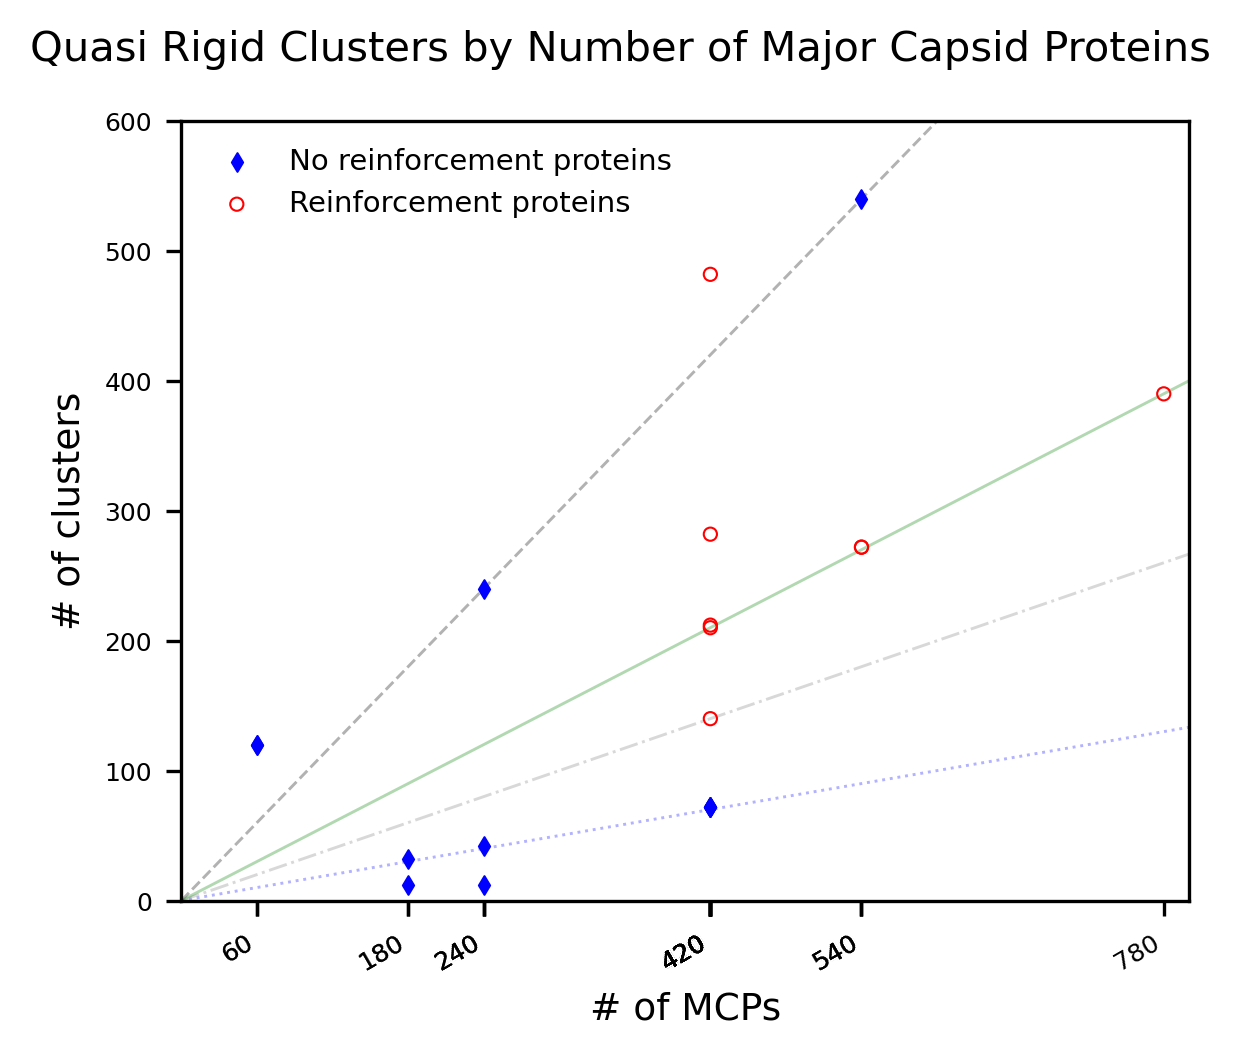

In [207]:
import matplotlib.pyplot as plt
import matplotlib

CCs = np.array(table['CC'])
cmask = CCs > 0.3

reinforcements = table['Reinforcement'][cmask]
p = np.array(table['# of MCPs'])[cmask]
p_nr = p[pd.isnull(reinforcements)]
p_r = p[~pd.isnull(reinforcements)]

n_c_nr = np.array(table['Clusters'])[cmask][pd.isnull(reinforcements)]
n_c_r = np.array(table['Clusters'])[cmask][~pd.isnull(reinforcements)]


ind = np.arange(CCs.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 7}
matplotlib.rc('font', **font)
matplotlib.rc('svg', fonttype='none')

ax.scatter(p_nr, n_c_nr, marker='d', color='blue', s=10, label='No reinforcement proteins', linewidth=0.5, zorder=2)
ax.scatter(p_r, n_c_r, marker = 'o', color='red', facecolors='none', s=10, label='Reinforcement proteins', linewidth=0.5, zorder=2)
ax.legend(fontsize=7, frameon=False)

def abline(slope, intercept, color, linestyle):
    """Plot a line from slope and intercept"""
    ax = plt.gca()
    px = np.array(ax.get_xlim())
    py = intercept + slope * px
    ax.plot(px,py, color = color, linestyle=linestyle, linewidth=0.7, zorder=1, alpha=0.3)

ax.set_xlim([0,800])
ax.set_ylim([0,600])


# protein line
abline(1,0, 'black', 'dashed')

# hex line
abline(1/6,2/60, 'blue', 'dotted')

# hex-dual line
abline(1/3,0, 'grey', 'dashdot')

# trihex-dual line
abline(1/2,2/60, 'green', 'solid')

ax.set_ylabel('# of clusters', fontsize=9)
ax.set_xlabel('# of MCPs', fontsize=9)
ax.set_xticks(p)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='x', labelsize=6)
fig.suptitle('Quasi Rigid Clusters by Number of Major Capsid Proteins', fontsize=10)
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/nmcp_clusters_final.svg')
plt.savefig('C:/Users/colin/OneDrive - San Diego State University (SDSU.EDU)/1_Summer_2022/Thesis_final/Figs/cluster_plots_fig/nmcp_clusters_final.png')
plt.show()